# <a id='toc1_'></a>[FYS5419: Project 1](#toc0_)
## <a id='toc1_1_'></a>[Author: Oskar Ekeid Idland](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [FYS5419: Project 1](#toc1_)    
  - [Author: Oskar Ekeid Idland](#toc1_1_)    
- [Imports](#toc2_)    
- [Types](#toc3_)    
- [a)](#toc4_)    
  - [Functions](#toc4_1_)    
  - [Playing with Qubits](#toc4_2_)    
  - [Exploring Pauli Matrices](#toc4_3_)    
  - [Exploring Gates](#toc4_4_)    
  - [Bell States](#toc4_5_)    
    - [Creation by Applying Gates](#toc4_5_1_)    
    - [Direct Creation](#toc4_5_2_)    
    - [Acting on the Bell State with Gates](#toc4_5_3_)    
    - [Testing by Measuring Bell States](#toc4_5_4_)    
  - [Circuit and Measurements in Qiskit](#toc4_6_)    
    - [Comparing Probabilities from Measurements](#toc4_6_1_)    
  - [Conclusion](#toc4_7_)    
- [b)](#toc5_)    
  - [Functions](#toc5_1_)    
  - [Finding Eigenvalues](#toc5_2_)    
  - [Conclusion](#toc5_3_)    
- [c)](#toc6_)    
  - [Functions](#toc6_1_)    
  - [Comparing VQE and Exact Eigenvalues](#toc6_2_)    
    - [Error Analysis](#toc6_2_1_)    
  - [Repeating the VQE calculation using qiskit's VQE algorithm](#toc6_3_)    
    - [Circuit](#toc6_3_1_)    
  - [Conclusion](#toc6_4_)    
- [d)](#toc7_)    
  - [Functions](#toc7_1_)    
    - [Analytical Solution](#toc7_1_1_)    
      - [Using SymPy](#toc7_1_1_1_)    
      - [Using the Results from Above](#toc7_1_1_2_)    
  - [Plotting Energy and Entropy](#toc7_2_)    
  - [Conclusion](#toc7_3_)    
- [e)](#toc8_)    
  - [Functions](#toc8_1_)    
  - [Comparing VQE and Exact Eigenvalues](#toc8_2_)    
    - [Error Analysis](#toc8_2_1_)    
  - [Conclusion](#toc8_3_)    
- [f)](#toc9_)    
  - [Defining the Hamiltonian for $J = 1$](#toc9_1_)    
  - [Rewriting the $J = 1$ Hamiltonian with Pauli Matrices](#toc9_2_)    
  - [Rewriting the $J = 2$ Hamiltonian with Pauli Matrices](#toc9_3_)    
- [g)](#toc10_)    
  - [Conclusion](#toc10_1_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc2_'></a>[Imports](#toc0_)

In [1]:
### Regular imports ###
import numpy as np
import sympy as sp
from time import time
from tqdm import tqdm
from numba import njit
from tabulate import tabulate
import matplotlib.pyplot as plt
from dataclasses import dataclass
from warnings import filterwarnings
from numpy.exceptions import ComplexWarning
from numpy import float64, complex128, ndarray
from typing import Annotated, Literal, Callable

### Customizations ###
np.set_printoptions(precision=3, sign=' ')
%matplotlib inline
plt.rcParams.update({'font.size': 12, 
                     'font.family': 'serif', 
                     'figure.figsize': (10, 6), 
                     'mathtext.fontset': 'cm',
                     'axes.prop_cycle': plt.cycler(color=["#3d0dce", 
                                                          "#ff1e1e", 
                                                          "#61ffa6",
                                                          "#86db0f",
                                                          "#f711ff",
                                                          "#64B5CD"]),
                     'lines.linewidth': 3,
                     'legend.fontsize': 12,
                    })
tensor_prod = np.kron

### Qiskit imports ###
from qiskit_aer import AerSimulator, Aer
from qiskit.visualization import plot_histogram
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit_algorithms import VQE, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import AQGD, COBYLA
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import Estimator

# <a id='toc3_'></a>[Types](#toc0_)

In [2]:
### Matplotlib Figure type ###
Figure = Annotated[plt.Figure, "Figure"]

### Indexing types ###
Indexing_2qbit = Annotated[Literal[0, 1,], "Valid 2 qubit indexing"]
Indexing_3qbit = Annotated[Literal[0, 1, 2], "Valid 3 qubit indexing"]

### Vectors ###
Array2D   = Annotated[ndarray[2, float],   "2D array"]
Array2D_c = Annotated[ndarray[2, complex], "2D complex array"]

Array4D   = Annotated[ndarray[4, float],   "4D array"]
Array4D_c = Annotated[ndarray[4, complex], "4D complex array"]

### Matrices ###
Array2x2   = Annotated[ndarray[(ndarray[2, float], 
                                ndarray[2, float])],   "2x2 matrix"]

Array2x2_c = Annotated[ndarray[(ndarray[2, complex],
                                ndarray[2, complex])], "2x2 complex matrix"]

Array4x4   = Annotated[ndarray[(ndarray[4, float],
                                ndarray[4, float])],   "4x4 matrix"]

Array4x4_c = Annotated[ndarray[(ndarray[4, complex],
                                ndarray[4, complex])], "4x4 complex matrix"]

Array5x5  = Annotated[ndarray[(ndarray[5, float],
                               ndarray[5, float])],   "5x5 matrix"]

Array5x5_c = Annotated[ndarray[(ndarray[5, complex],
                                ndarray[5, complex])], "5x5 complex matrix"]

# <a id='toc4_'></a>[a)](#toc0_)

## <a id='toc4_1_'></a>[Functions](#toc0_)

In [3]:
@njit
def qubit_basis() -> tuple[Array2D, Array2D]:
    '''
    Creates the qubits standard qubit basis: |0⟩ and |1⟩.
    
    Returns
    -------
        q0: Array2D
            |0⟩ = [1, 0]
        q1: Array2D
            |1⟩ = [0, 1]
    '''
    q0: Array2D = np.array([1, 0])
    q1: Array2D = np.array([0, 1])
    return q0, q1

@njit
def pauli() -> tuple[Array2x2_c, Array2x2_c, Array2x2_c]:
    '''
    Creates the Pauli matrices σ_x, σ_y, and σ_z.
    
    Returns
    -------
        σ_x: Array2x2_c
            Pauli X
        σ_y: Array2x2_c
            Pauli Y
        σ_z: Array2x2_c
            Pauli Z
    '''
    σ_x: Array2x2_c = np.array([[0,  1 ],  
                                [1,  0]], dtype=complex128)
    
    σ_y: Array2x2_c = np.array([[0, -1j],  
                                [1j, 0]], dtype=complex128)
    
    σ_z: Array2x2_c = np.array([[1,  0 ],  
                                [0, -1]], dtype=complex128)
    return σ_x, σ_y, σ_z

def hadamard() -> Array2x2:
    '''
    Creates the Hadamard gate.
    
    Returns
    -------
        H: Array2x2
            Hadamard gate
    '''
    H: Array2x2 = 1/np.sqrt(2) * np.array([[1, 1], 
                                           [1, -1]])
    return H

def phase() -> Array2x2_c:
    '''
    Creates the phase gate.

    Returns
    -------
        S: Array2x2_c
            Phase gate
    '''
    S = np.array([[1,  0], 
                  [0, 1j]])
    return S

@njit
def cnot() -> Array4x4_c: 
    '''
    Creates the CNOT gate.
    
    Returns
    -------
        CNOT: Array4x4_c
            CNOT gate
    '''
    CNOT: Array4x4_c = np.array([[1, 0, 0, 0], 
                                 [0, 1, 0, 0], 
                                 [0, 0, 0, 1], 
                                 [0, 0, 1, 0]], dtype=complex128)
    return CNOT

def create_bell_states() -> tuple[Array4D, Array4D, Array4D, Array4D]:
    '''
    Creates the Bell states |Φ⁺⟩, |Φ⁻⟩, |Ψ^+⟩, and |Ψ⁻⟩.
    
    Returns
    -------
        Φ_00: Array4x4
            |Φ⁺⟩ = (|00⟩ + |11⟩)/√2
        Φ_10: Array4x4
            |Φ⁻⟩ = (|00⟩ - |11⟩)/√2
        Ψ_01: Array4x4
            |Ψ⁺⟩ = (|01⟩ + |10⟩)/√2
        Ψ_11: Array4x4
            |Ψ⁻⟩ = (|01⟩ - |10⟩)/√2
    '''
    q0, q1 = qubit_basis()

    H:    Array2x2 = hadamard()
    CNOT: Array4D_c = cnot()

    q0_H: Array2D = H @ q0
    q1_H: Array2D = H @ q1

    Φ_00: Array4D = CNOT @ tensor_prod(q0_H, q0) # |Φ⁺⟩ = (|00⟩ + |11⟩)/√2
    Φ_10: Array4D = CNOT @ tensor_prod(q1_H, q0) # |Φ⁻⟩ = (|00⟩ - |11⟩)/√2
    Ψ_01: Array4D = CNOT @ tensor_prod(q0_H, q1) # |Ψ⁺⟩ = (|01⟩ + |10⟩)/√2
    Ψ_11: Array4D = CNOT @ tensor_prod(q1_H, q1) # |Ψ⁻⟩ = (|01⟩ - |10⟩)/√2
    
    return Φ_00, Φ_10, Ψ_01, Ψ_11

def create_system_vectors(n_qubits: int) -> list[ndarray[float64]]:
    """
    Create the system vectors for a given number of qubits.
    
    Parameters
    ----------
    n_qubits : int
        The number of qubits in the system.
        
    Returns
    -------
    system_vectors : list[ndarray[int]]
        A list of system vectors, where each vector represents a possible state of the qubits. For n_qubits there are 2^n_qubits possible states returned.
    """
    q0, q1 = qubit_basis()
    system_vectors = []
    for i in range(2**n_qubits):
        binary_str = f'{i:0{n_qubits}b}'
        state = np.array([1])
        for bit in binary_str:
            state = tensor_prod(state, q0 if bit == '0' else q1)
        system_vectors.append(state)
        
    return system_vectors
    
        

def measure_qubit(qubit: Indexing_2qbit, bell_state: Array4D) -> Literal[0, 1]:
    '''
    Makes a measurement on a specified cubit in a Bell state
    
    Parameters
    ----------
        qubit: int
            Which cubit to measure. In a two-qubit state one could pass either 0 or 1
        bell_state: Array4D
            The state to measure
        
    Returns
    -------
        state: Literal[0, 1]
            What state the qubit is in. Either 0 or 1
    '''
    if qubit not in [0, 1]:
        raise ValueError(f"Invalid qubit index. Must be either 0 or 1, not {qubit}")
    
    n = len(bell_state)
    n_qubits = int(np.log2(n))
    
    measurement_probabilities = {'0': 0, '1': 0}
    for i in range(n):
        binary_str = f'{i:0{n_qubits}b}'[qubit] # Count in binary, 0-padded to the number of qubits and extract the qubit we want
        prob = bell_state[i]
        measurement_probabilities[binary_str] += np.abs(prob)**2
        
    # Weighted random choice depending on the state
    result = np.random.choice([0, 1], p=[*measurement_probabilities.values()])

    return result

def measure_system(bell_state: Array4D) -> Literal['00', '01', '10', '11']:
    '''
    Makes a measurement on all qubits in a Bell state

    Parameters
    ----------
        bell_state: Array4D
            The state to measure

    Returns
    -------
        state: Literal['00', '01', '10', '11']
            What state the qubits are in. For a two-qubit system, this would be either '00', '01', '10', or '11'
    '''
    measurement_probabilities = {'00': 0, '01': 0, '10': 0, '11': 0}
    for i, bin_str in enumerate(measurement_probabilities.keys()):
        prob = bell_state[i]
        measurement_probabilities[bin_str] += np.abs(prob)**2
        
    # Weighted random choice depending on the state
    result = np.random.choice(a=[*measurement_probabilities.keys()], 
                              p=[*measurement_probabilities.values()])
    return result

## <a id='toc4_2_'></a>[Playing with Qubits](#toc0_)
- The following explores how the qubit states can be combined to form composite states. 
- I also explore how their connection to the bit string representation of the state. 
- There seems to be a natural connection between the bit string representation and the order of the qubits in the tensor product. This is used to define the order of the qubits in the tensor product.

In [4]:
# Checking the states being as expected and their corresponding binary representation
n_qubits = 2
v1, v2, v3, v4 = create_system_vectors(n_qubits)

bin_strs = [f'{i:0{n_qubits}b}' for i in range(2**n_qubits)]

q0, q1 = qubit_basis()

table = tabulate([[bin_strs[0], '|0⟩⊗|0⟩', tensor_prod(q0, q0), v1],
                  [bin_strs[1], '|0⟩⊗|1⟩', tensor_prod(q0, q1), v2],
                  [bin_strs[2], '|1⟩⊗|0⟩', tensor_prod(q1, q0), v3],
                  [bin_strs[3], '|1⟩⊗|1⟩', tensor_prod(q1, q1), v4]],
                  headers  = ['Binary', 'Product', 'Expected', 'Calculated'],
                  tablefmt = 'outline',
                  colalign = ['right', 'center', 'center', 'center']
                )
print(table)

+----------+-----------+---------------+---------------+
|   Binary |  Product  |   Expected    |  Calculated   |
+==========+===========+===============+===============+
|       00 |  |0⟩⊗|0⟩  | [ 1  0  0  0] | [ 1  0  0  0] |
|       01 |  |0⟩⊗|1⟩  | [ 0  1  0  0] | [ 0  1  0  0] |
|       10 |  |1⟩⊗|0⟩  | [ 0  0  1  0] | [ 0  0  1  0] |
|       11 |  |1⟩⊗|1⟩  | [ 0  0  0  1] | [ 0  0  0  1] |
+----------+-----------+---------------+---------------+


In [5]:
# Checking the states being as expected
n_qubits = 3
v1, v2, v3, v4, v5, v6, v7, v8 = create_system_vectors(n_qubits)

bin_strs = [f'{i:0{n_qubits}b}' for i in range(2**n_qubits)]

q0, q1 = qubit_basis()

table = tabulate([[bin_strs[0], '|0⟩⊗|0⟩⊗|0⟩', tensor_prod(tensor_prod(q0, q0), q0), v1],
                  [bin_strs[1], '|0⟩⊗|0⟩⊗|1⟩', tensor_prod(tensor_prod(q0, q0), q1), v2],
                  [bin_strs[2], '|0⟩⊗|1⟩⊗|0⟩', tensor_prod(tensor_prod(q0, q1), q0), v3],
                  [bin_strs[3], '|0⟩⊗|1⟩⊗|1⟩', tensor_prod(tensor_prod(q0, q1), q1), v4],
                  [bin_strs[4], '|1⟩⊗|0⟩⊗|0⟩', tensor_prod(tensor_prod(q1, q0), q0), v5],
                  [bin_strs[5], '|1⟩⊗|0⟩⊗|1⟩', tensor_prod(tensor_prod(q1, q0), q1), v6],
                  [bin_strs[6], '|1⟩⊗|1⟩⊗|0⟩', tensor_prod(tensor_prod(q1, q1), q0), v7],
                  [bin_strs[7], '|1⟩⊗|1⟩⊗|1⟩', tensor_prod(tensor_prod(q1, q1), q1), v8]],
                  headers  = ['Binary', 'Product', 'Expected', 'Calculated'],
                  tablefmt = 'outline',
                  colalign = ['right', 'center', 'center', 'center']
                )
print(table)

+----------+-------------+---------------------------+---------------------------+
|   Binary |   Product   |         Expected          |        Calculated         |
+==========+=============+===========================+===========================+
|      000 | |0⟩⊗|0⟩⊗|0⟩ | [ 1  0  0  0  0  0  0  0] | [ 1  0  0  0  0  0  0  0] |
|      001 | |0⟩⊗|0⟩⊗|1⟩ | [ 0  1  0  0  0  0  0  0] | [ 0  1  0  0  0  0  0  0] |
|      010 | |0⟩⊗|1⟩⊗|0⟩ | [ 0  0  1  0  0  0  0  0] | [ 0  0  1  0  0  0  0  0] |
|      011 | |0⟩⊗|1⟩⊗|1⟩ | [ 0  0  0  1  0  0  0  0] | [ 0  0  0  1  0  0  0  0] |
|      100 | |1⟩⊗|0⟩⊗|0⟩ | [ 0  0  0  0  1  0  0  0] | [ 0  0  0  0  1  0  0  0] |
|      101 | |1⟩⊗|0⟩⊗|1⟩ | [ 0  0  0  0  0  1  0  0] | [ 0  0  0  0  0  1  0  0] |
|      110 | |1⟩⊗|1⟩⊗|0⟩ | [ 0  0  0  0  0  0  1  0] | [ 0  0  0  0  0  0  1  0] |
|      111 | |1⟩⊗|1⟩⊗|1⟩ | [ 0  0  0  0  0  0  0  1] | [ 0  0  0  0  0  0  0  1] |
+----------+-------------+---------------------------+---------------------------+


## <a id='toc4_3_'></a>[Exploring Pauli Matrices](#toc0_)

In [6]:

q0, q1 = qubit_basis()
σ_x, σ_y, σ_z = pauli()

q0_x: Array2D_c = σ_x @ q0
q0_y: Array2D_c = σ_y @ q0
q0_z: Array2D_c = σ_z @ q0

q1_x: Array2D_c = σ_x @ q1
q1_y: Array2D_c = σ_y @ q1
q1_z: Array2D_c = σ_z @ q1

print(f'σ_x|0⟩ = {q0_x}')
print(f'σ_y|0⟩ = {q0_y}')
print(f'σ_z|0⟩ = {q0_z}')
print()
print(f'σ_x|1⟩ = {q1_x}')
print(f'σ_y|1⟩ = {q1_y}')
print(f'σ_z|1⟩ = {q1_z}')

σ_x|0⟩ = [ 0.+0.j  1.+0.j]
σ_y|0⟩ = [ 0.+0.j  0.+1.j]
σ_z|0⟩ = [ 1.+0.j  0.+0.j]

σ_x|1⟩ = [ 1.+0.j  0.+0.j]
σ_y|1⟩ = [ 0.-1.j  0.+0.j]
σ_z|1⟩ = [ 0.+0.j -1.+0.j]


## <a id='toc4_4_'></a>[Exploring Gates](#toc0_)

In [7]:
H: Array2x2   = hadamard()
S: Array2x2_c = phase()

q0_H = H @ q0
q0_S = S @ q0

q1_H = H @ q1
q1_S = S @ q1

print(f'H|0⟩ = {q0_H}')
print(f'S|0⟩ = {q0_S}')
print()
print(f'H|1⟩ = {q1_H}')
print(f'S|1⟩ = {q1_S}')

H|0⟩ = [ 0.707  0.707]
S|0⟩ = [ 1.+0.j  0.+0.j]

H|1⟩ = [ 0.707 -0.707]
S|1⟩ = [ 0.+0.j  0.+1.j]


## <a id='toc4_5_'></a>[Bell States](#toc0_)
Example of a Bell State and how to create it using a circuit. In this case, the Bell State $|Φ^{+}⟩$ is created using a Hadamard gate and a CNOT gate: 
$$
|Φ^{+}⟩ =  \frac{1}{\sqrt{2}}\Big(|00⟩ + |11⟩\Big)
$$ 

![image.png](./attatchments/bell_state.png)

### <a id='toc4_5_1_'></a>[Creation by Applying Gates](#toc0_)

In [8]:
Φ_00, Φ_10, Ψ_01, Ψ_11 = create_bell_states()

print(f'|Φ⁺⟩ = {Φ_00}')
print(f'|Φ⁺⟩ = {Φ_10}')
print(f'|Ψ⁺⟩ = {Ψ_01}')
print(f'|Ψ⁺⟩ = {Ψ_11}')

|Φ⁺⟩ = [ 0.707+0.j  0.   +0.j  0.   +0.j  0.707+0.j]
|Φ⁺⟩ = [ 0.707+0.j  0.   +0.j  0.   +0.j -0.707+0.j]
|Ψ⁺⟩ = [ 0.   +0.j  0.707+0.j  0.707+0.j  0.   +0.j]
|Ψ⁺⟩ = [ 0.   +0.j  0.707+0.j -0.707+0.j  0.   +0.j]


### <a id='toc4_5_2_'></a>[Direct Creation](#toc0_)

In [9]:
q_00, q_01, q_10, q_11 = create_system_vectors(2)

Φ_00 = 1/np.sqrt(2) * (q_00 + q_11)
Φ_10 = 1/np.sqrt(2) * (q_00 - q_11)
Ψ_01 = 1/np.sqrt(2) * (q_01 + q_10)
Ψ_11 = 1/np.sqrt(2) * (q_01 - q_10)

print(f'|Φ⁺⟩ = {Φ_00}')
print(f'|Φ⁻⟩ = {Φ_10}')
print(f'|Ψ⁺⟩ = {Ψ_01}')
print(f'|Ψ⁻⟩ = {Ψ_11}')

|Φ⁺⟩ = [ 0.707  0.     0.     0.707]
|Φ⁻⟩ = [ 0.707  0.     0.    -0.707]
|Ψ⁺⟩ = [ 0.     0.707  0.707  0.   ]
|Ψ⁻⟩ = [ 0.     0.707 -0.707  0.   ]


### <a id='toc4_5_3_'></a>[Acting on the Bell State with Gates](#toc0_)

In [10]:
H = hadamard()
CNOT = cnot()
I_2 = np.eye(2)

# Applying the Hadamard and CNOT gate to the first Bell state
Φ_00_H = tensor_prod(H, I_2) @ Φ_00
Φ_00_H_CNOT = CNOT @ Φ_00_H

print(f'|Φ⁺⟩ =          {Φ_00}')
print(f'(H⊗I)|Φ⁺⟩ =     {Φ_00_H}')
print(f'CNOT(H⊗I)|Φ⁺⟩ = {Φ_00_H_CNOT}')

|Φ⁺⟩ =          [ 0.707  0.     0.     0.707]
(H⊗I)|Φ⁺⟩ =     [ 0.5  0.5  0.5 -0.5]
CNOT(H⊗I)|Φ⁺⟩ = [ 0.5+0.j  0.5+0.j -0.5+0.j  0.5+0.j]


### <a id='toc4_5_4_'></a>[Testing by Measuring Bell States](#toc0_)

In [11]:
# Making a measurment
q0_results = {0: 0, 1: 0}
q1_results = {0: 0, 1: 0}
n_lambdas = 10_000
for i in range(n_lambdas):
    q0_res = measure_qubit(0, Φ_00)
    q0_results[q0_res] += 1
    
    q1_res = measure_qubit(1, Φ_00)
    q1_results[q1_res] += 1

Odds of measuring qubit 0 as 0:,  49.83%
Odds of measuring qubit 0 as 1:,  50.17%


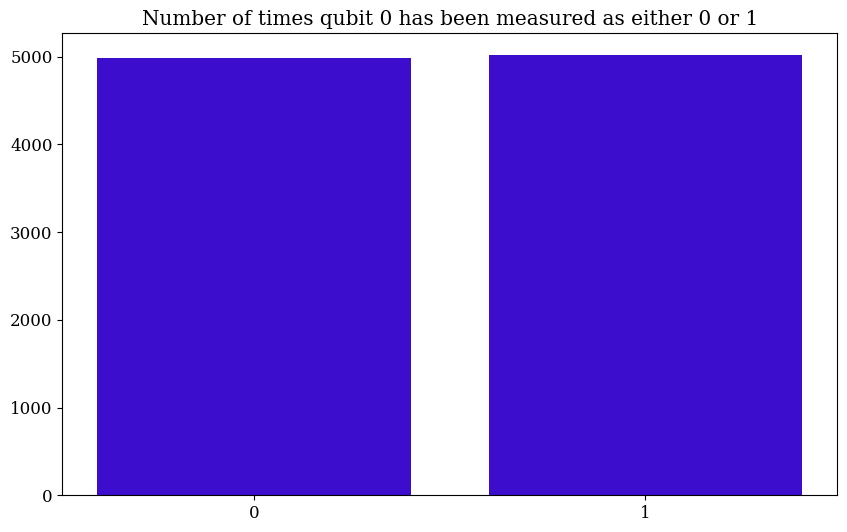

In [12]:
print(f'Odds of measuring qubit 0 as 0:, {q0_results[0]/n_lambdas: .2%}')
print(f'Odds of measuring qubit 0 as 1:, {q0_results[1]/n_lambdas: .2%}')

plt.bar(q0_results.keys(), q0_results.values())
plt.xticks([0, 1])
plt.title("Number of times qubit 0 has been measured as either 0 or 1")
plt.savefig('figs/a_q0_measurement.pdf')
plt.show()

Odds of measuring qubit 0 as 0:,  49.74%
Odds of measuring qubit 0 as 1:,  50.26%


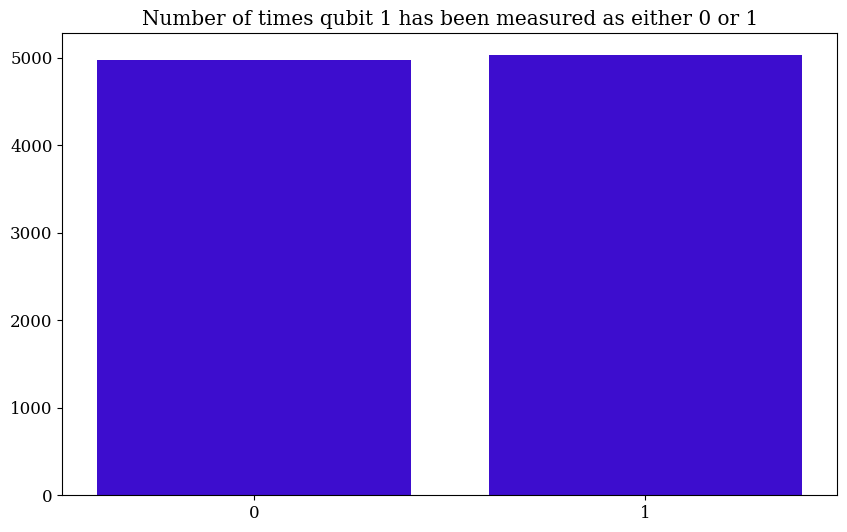

In [13]:
print(f'Odds of measuring qubit 0 as 0:, {q1_results[0]/n_lambdas: .2%}')
print(f'Odds of measuring qubit 0 as 1:, {q1_results[1]/n_lambdas: .2%}')

plt.bar(q1_results.keys(), q1_results.values())
plt.xticks([0, 1])
plt.title("Number of times qubit 1 has been measured as either 0 or 1")
plt.savefig('figs/a_q1_measurement.pdf')
plt.show()

## <a id='toc4_6_'></a>[Circuit and Measurements in Qiskit](#toc0_)

<IPython.core.display.Javascript object>

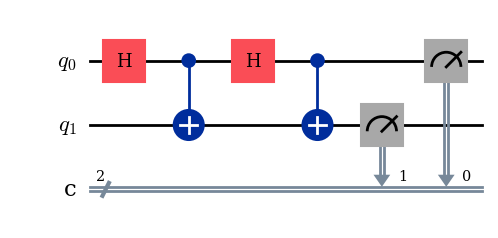

In [14]:
qc = QuantumCircuit(2, 2)
qc.h(0)
qc.cx(0, 1)
qc.h(0)
qc.cx(0, 1)

# Measureing the qubits
qc.measure(1, 1)
qc.measure(0, 0)
# Needed for qiskit drawing
%matplotlib notebook 
qc.draw('mpl')

In [15]:
# Makes the plots static again after the qiskit drawing
%matplotlib inline

### <a id='toc4_6_1_'></a>[Comparing Probabilities from Measurements](#toc0_)

Probabilities of measuring the Bell states in Qiskit and Python
---------------------------------------------------------------
+---------+----------+----------+
|  State  |  Qiskit  |  Python  |
+=========+==========+==========+
|  |00⟩   |  24.78%  |  25.22%  |
|  |01⟩   |  25.10%  |  24.95%  |
|  |10⟩   |  24.88%  |  24.86%  |
|  |11⟩   |  25.24%  |  24.97%  |
+---------+----------+----------+


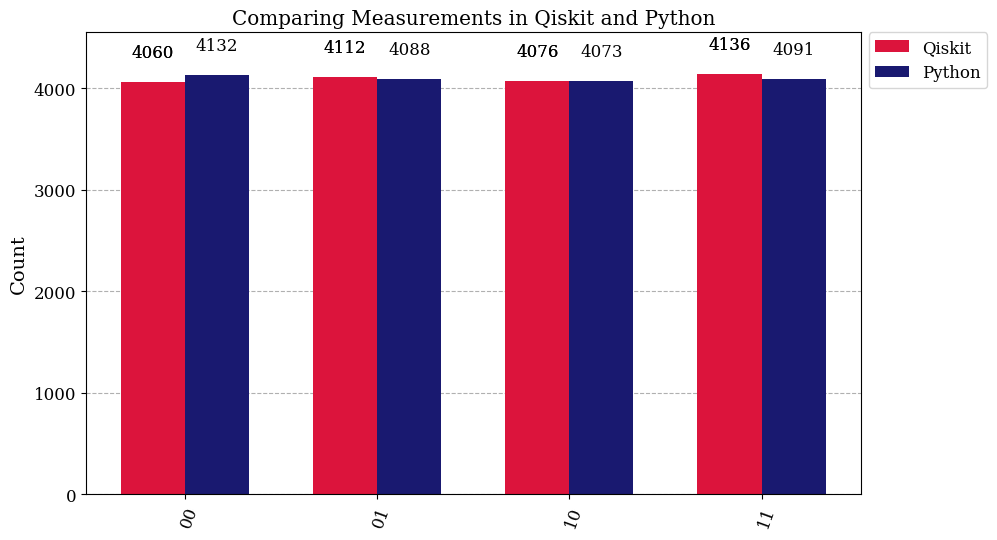

In [16]:
simulator = AerSimulator()
n_lambdas = 2**14
results_qk = simulator.run(qc, shots=n_lambdas).result().get_counts(qc)
results_qk = dict(sorted(results_qk.items(), key=lambda x: x[0])) # Sort the results by bit string key

# Extracting the probabilities
prob_qk = {key: val/n_lambdas for key, val in results_qk.items()}

# Comparing with python implementation
H = hadamard()
CNOT = cnot()
Φ_00 = create_bell_states()[0]

state = CNOT @ tensor_prod(H, I_2) @ Φ_00

results_py = {f'{i:02b}': 0 for i in range(4)}
for i in range(n_lambdas):
    res = measure_system(state)
    results_py[res] += 1

# Extracting the probabilities
prob_py = {key: val/n_lambdas for key, val in results_py.items()}

table = tabulate([["|00⟩", f'{prob_qk['00']: .2%}', f'{prob_py["00"]: .2%}'],
                  ["|01⟩", f'{prob_qk['01']: .2%}', f'{prob_py["01"]: .2%}'],
                  ["|10⟩", f'{prob_qk['10']: .2%}', f'{prob_py["10"]: .2%}'],
                  ["|11⟩", f'{prob_qk['11']: .2%}', f'{prob_py["11"]: .2%}']],
                  headers  = ['State', 'Qiskit', 'Python'],
                  tablefmt = 'outline',
                  colalign = ['center', 'center', 'center']
                )
print("Probabilities of measuring the Bell states in Qiskit and Python")
print("---------------------------------------------------------------")
print(table)


fig = plot_histogram([results_qk, results_py], title="Comparing Measurements in Qiskit and Python", 
                     legend=['Qiskit', 'Python'], color=['crimson', 'midnightblue'] )

fig.savefig('figs/a_qiskit_vs_python.pdf')
fig.savefig('selected_results/a_qiskit_vs_python.pdf')
plt.show()

## <a id='toc4_7_'></a>[Conclusion](#toc0_)
- As we can see, the qubit states can be combined to form composite states using the tensor product of $|0⟩$ and $|1⟩$.
- We looked at the bell state $|Φ^{+}⟩$, in which both qubits are either in the state $|0⟩$, represented by $|00⟩$, or $|1⟩$ represented by $|11⟩$. 
- Applying a Hadamard and CNOT gate to $|Φ^{+}⟩$, we get the expected results of approximately a 25% chance of measuring either $|00⟩$, $|01⟩$, $|10⟩$  or $|11⟩$.

# <a id='toc5_'></a>[b)](#toc0_)

## <a id='toc5_1_'></a>[Functions](#toc0_)

In [17]:
@njit
def Hamiltonian_1qbit(λ: float) -> Array2x2_c:
    '''
    Creates the Hamiltonian for a given interaction strength λ.
    
    Parameters
    ----------
        λ: float
            The interaction strength
    
    Returns
    -------
        H: Array2x2_c
            The complex 2x2 Hamiltonian matrix
    '''
    
    E1 = 0
    E2 = 4
    E = (E1 + E2) / 2
    Ω = (E1 - E2) / 2
    σ_x, σ_y, σ_z = pauli()
    I_2 = np.eye(2, dtype=complex128)
    H0 = E*I_2 + Ω*σ_z

    V11 = 3 
    V22 = -V11 
    V12 = V21 = 0.2
    c = (V11 + V22) / 2
    ω_z = (V11 - V22) / 2
    ω_x = V12
    HI = c*I_2 + ω_z*σ_z + ω_x*σ_x
    
    H = H0 + λ*HI
    return H

## <a id='toc5_2_'></a>[Finding Eigenvalues](#toc0_)

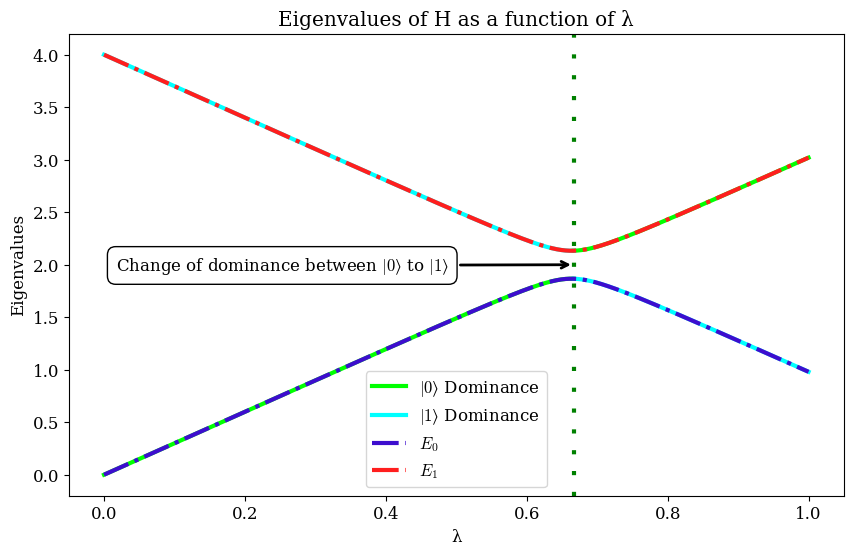

In [18]:
n_lambdas = 10001
lambdas = np.linspace(0, 1, n_lambdas)
energy_eigvals = [np.linalg.eigvalsh(Hamiltonian_1qbit(λ)).real for λ in lambdas] # Our Hamiltonian is Hermitian, so the eigenvalues are real. Casting to real to avoid warnings
E_0, E_1 = np.array(energy_eigvals).T

switch_value = lambdas < 2/3

# Plotting energy eigenstate 0's energy
plt.plot(lambdas[switch_value],  E_0[switch_value], label=r'$|0⟩$ Dominance', color='lime')
plt.plot(lambdas[~switch_value], E_1[~switch_value], color='lime')

# Plotting energy eigenstate 1's energy
plt.plot(lambdas[switch_value],  E_1[switch_value], label=r'$|1⟩$ Dominance', color='aqua')
plt.plot(lambdas[~switch_value], E_0[~switch_value], color='aqua')

# Plotting the eigenvalues
plt.plot(lambdas, energy_eigvals, label=(r'$E_0$', r'$E_1$'), linestyle='-.',)

x = 2/3
y = (energy_eigvals[int(2/3*n_lambdas)][0] + energy_eigvals[int(2/3*n_lambdas)][1]) / 2 # Average of the two eigenvalues
plt.annotate(text=r"Change of dominance between $|0⟩$ to $|1⟩$", 
             xy=(x, y), 
             xytext=(x-.65, y-.05),
             arrowprops=dict(arrowstyle='->', lw=2), 
             bbox=dict(facecolor='white',
             edgecolor='black',
             boxstyle='round,pad=0.5')), 

plt.axvline(x=2/3, color='green', linestyle=(0, (1, 4))) # Marking the change of dominance
plt.xlabel('λ')
plt.ylabel('Eigenvalues')
plt.title('Eigenvalues of H as a function of λ')
plt.legend()
plt.savefig('figs/b_eigenvalues.pdf')
plt.savefig('selected_results/b_eigenvalues.pdf')
plt.show()

## <a id='toc5_3_'></a>[Conclusion](#toc0_)
- As the interacting term $λ$ increases, the first energy eigenstate increases in energy, while the second energy eigenstate decreases in energy. They soon after diverge at $λ = 2/3$.
- At $λ = 2/3 $, we see a switch in dominance between which part of our basis is the largest contributor to the energy eigenstates. 

# <a id='toc6_'></a>[c)](#toc0_)

## <a id='toc6_1_'></a>[Functions](#toc0_)

In [19]:
@njit
def Rx(θ: float) -> Array2x2_c:
    '''
    Rotation around the x-axis
    
    Parameters
    ----------
        θ: float
            The angle (radians) to rotate by
    
    Returns
    -------
        Rx: Array2x2_c
            The complex 2x2 rotation matrix
    '''
    I_2 = np.eye(2)
    X = np.array([[0, 1], [1, 0]], dtype=complex128)
    return np.cos(θ*0.5) * I_2-1j * np.sin(θ*0.5) * X

@njit
def Ry(ϕ: float) -> Array2x2_c:
    '''
    Rotation around the y-axisChange of groundstate bewteen energy eigenstate 0 and 2
    
    Parameters
    ----------
        ϕ: float
            The angle (radians) to rotate by
            
    Returns
    -------
        Ry: Array2x2_c
            The complex 2x2 rotation matrix
    '''
    I_2 = np.eye(2)
    Y = np.array([[0, -1j], [1j, 0]])
    return np.cos(ϕ*0.5) * I_2-1j * np.sin(ϕ*0.5) * Y

@njit
def Energy_1qbit(θ: float, ϕ: float, λ: float) -> float:
    '''
    Calculates the energy eigenvalues of the Hamiltonian for a 1-qubit system
    
    Parameters
    ----------
        θ: float
            The angle (radians) to rotate by around the x-axis
        ϕ: float
            The angle (radians) to rotate by around the y-axis
        λ: float
            The interaction strength
            
    Returns
    -------
        E: float
            The energy eigenvalue (real)
    '''
    q0, q1 = qubit_basis()
    q0: Array2D_c = q0.astype(complex128) # Promoted to complex for njit
    
    basis = q0 # |0⟩: Will be rotated anyways so no need to use |1⟩    
    rotated_basis = Rx(θ) @ Ry(ϕ) @ basis
    E = rotated_basis.conj().T @ Hamiltonian_1qbit(λ) @ rotated_basis
    
    assert abs(E.imag) < 1e-14, f'Energy is complex. Something went wrong: E = {E}, type(E) = {type(E)}'
    return E.real

@njit
def VQE_1qbit(n_iterations: int, η: float, λ: float = 0, seed: int = 2024) -> float:
    '''
    Variational Quantum Eigensolver using Gradient Descent to find the minimum energy
    
    Parameters
    ----------
        N_iterations: int
            Number of iterations
        η: float
            Learning rate
        λ: float
            Interaction strength of the Hamiltonian
        seed: int
            Seed for the random number generator
            
    Returns
    -------
        Energy(θ, ϕ, λ): float
            The lowest energy eigenvalue found in n iterations (real)
    '''
    π = np.pi
    np.random.seed(seed)
    θ = 2*π*np.random.rand()
    ϕ = 2*π*np.random.rand()
    for _ in range(n_iterations):
        ΔE_Δθ = (Energy_1qbit(θ+π/2, ϕ, λ) - Energy_1qbit(θ-π/2, ϕ, λ)) / 2
        ΔE_Δϕ = (Energy_1qbit(θ, ϕ+π/2, λ) - Energy_1qbit(θ, ϕ-π/2, λ)) / 2
        θ -= η * ΔE_Δθ
        ϕ -= η * ΔE_Δϕ
        
    E = Energy_1qbit(θ, ϕ, λ)
    return E

@dataclass
class Benchmark_Results():
    '''
    Dataclass for the benchmark results
    
    Parameters
    ----------
        eig_vals_vqe: ndarray
            The energy eigenvalues found by the VQE algorithm
        eig_vals_numpy: ndarray
            The energy eigenvalues found by numpy
        lambdas: ndarray
            Interaction strengths
        alg_name: str
            The name of the VQE algorithm
        switch_point: float (optional) = None
            The interaction strength where the groundstate changes
    '''
    eig_vals_vqe: ndarray
    eig_vals_np:  ndarray
    lambdas:      ndarray
    alg_name:     str
    switch_point: float = None


def benchmark_VQE(VQE_alg: Callable, Hamiltonian: Callable, n_iterations: int, η: float, lambdas: ndarray) -> Benchmark_Results:
    '''
    Benchmarks a VQE algorithm for a given number of iterations and learning rate. Compares the results with numpy
    
    Parameters
    ----------
        VQE_alg: Callable
            The VQE algorithm to benchmark
        Hamiltonian: Callable
            The Hamiltonian to pass to numpy
        n_iterations: int
            Number of iterations
        η: float
            Learning rate
        lambdas: ndarray
            Interaction strengths to benchmark
    
    Returns
    -------
        result: Benchmark_Results
            The benchmark results stored in a dataclass
    '''

    start = time()
    eig_vals_vqe = np.array([VQE_alg(n_iterations, η, λ) for λ in lambdas])
    vqe_time_cold = time() - start
    
    start = time()
    eig_vals_vqe = np.array([VQE_alg(n_iterations, η, λ) for λ in lambdas])
    vqe_time_warm = time() - start
    
    start = time()
    eig_vals_numpy = [np.min(np.linalg.eigvals(Hamiltonian(λ))).real for λ in lambdas] # Our Hamiltonian is Hermitian, so the eigenvalues are real. Casting to real to avoid warnings
    numpy_time = time() - start
    
    name = VQE_alg.__name__
    table = [["Method", "Time (s)", "Times Slower than Numpy"],
             [f"{name} (cold)", f"{vqe_time_cold:.2g}", f"{vqe_time_cold/numpy_time:.2f}"],
             [f"{name} (warm)", f"{vqe_time_warm:.2g}", f"{vqe_time_warm/numpy_time:.2f}"],
             ["Numpy", f"{numpy_time:.2g}", "1.00"]
    ]
    print(tabulate(table, headers="firstrow", tablefmt="grid"))
    
    result: Benchmark_Results = Benchmark_Results(eig_vals_vqe, eig_vals_numpy, lambdas, name)
    return result


def plot_relative_error(result: Benchmark_Results) -> Figure:
    '''
    Plots a comparison between the VQE algorithm and numpy and prints a nicely formatted table. Shows the figure
    
    Parameters
    ----------
        result: Benchmark_Results
            The benchmark results stored in dataclass
            
    Returns
    -------
        fig: Figure
            The matplotlib figure (`plt.show()` will be called)
    '''
    eig_vals_vqe = result.eig_vals_vqe
    eig_vals_numpy = result.eig_vals_np
    lambdas = result.lambdas
    
    filterwarnings("ignore", category=RuntimeWarning) # Ignore RuntimeWarning for division by zero
    relative_error = np.abs(eig_vals_vqe - eig_vals_numpy) / np.abs(eig_vals_numpy)
    filterwarnings("default", category=RuntimeWarning) # Turn warning back on
    
    plt.plot(lambdas, relative_error, label=f'Relative error')
    
    switch_point = result.switch_point
    plt.axvline(x=switch_point, color='green', linestyle=(0, (1, 5)), label=f'λ = {switch_point: .3f}')
    
    width = 1/15
    plt.axvspan(switch_point - width, switch_point + width , color='red', alpha=0.2, label='Area of larger error')
    
    zeros = np.where(relative_error == 0)[0]
    if len(zeros) > 0:
        plt.scatter(lambdas[zeros], relative_error[zeros], color='black', label='Zero relative error')
    
    plt.xlabel('λ')
    plt.ylabel('Relative error')
    
    percentage_formatter = lambda x, _: f'{x*100:1g}%'
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(percentage_formatter))
    plt.legend()
    
    return plt.gcf()
    
def plot_eigvals(result: Benchmark_Results) -> Figure:
    '''
    Plots a comparison between the VQE algorithm and numpy
    
    Parameters
    ----------
        result: Benchmark_Results
            The benchmark results stored in a named tuple
    '''
    eig_vals_vqe = result.eig_vals_vqe
    eig_vals_numpy = result.eig_vals_np
    lambdas = result.lambdas
    switch_point = result.switch_point
    alg_name = result.alg_name
    
    plt.plot(lambdas, eig_vals_vqe, label=f'{alg_name}')
    plt.plot(lambdas, eig_vals_numpy, label='Numpy', linestyle='--')
    
    plt.axvline(x=switch_point, color='green', linestyle=(0, (1, 5)), label=f'λ = {switch_point: .3f}')
    plt.xlabel('λ')
    plt.ylabel('Energy eigenvalues')
    plt.legend()
    
    return plt.gcf()

def error_statistics(result: Benchmark_Results) -> None: 
    '''
    Prints out statistics for the benchmark results
    
    Parameters
    ----------
        result: Benchmark_Results
            The benchmark results stored in a named tuple
    '''
    eig_vals_vqe = result.eig_vals_vqe
    eig_vals_numpy = result.eig_vals_np
    
    filterwarnings("ignore", category=RuntimeWarning) # Ignore RuntimeWarning for division by zero
    relative_error = np.abs(eig_vals_vqe - eig_vals_numpy) / np.abs(eig_vals_numpy)
    filterwarnings("default", category=RuntimeWarning) # Turn warning back on
    
    # Remove infinites after division by zero
    non_inf = np.isfinite(relative_error)
    relative_error = relative_error[non_inf]
    
    mean_error   = np.mean(relative_error)
    median_error = np.median(relative_error)
    max_error    = np.max(relative_error)
    min_error    = np.min(relative_error)
    std_error    = np.std(relative_error)
    
    table = [["Mean",   f'{mean_error*100: .1g}%'], 
             ["Median", f'{median_error*100: .1g}%'],
             ["Max",    f'{max_error*100: .1g}%'],
             ["Min",    f'{min_error*100: .1g}%'],
             ["Std",   f'{std_error*100: .1g}%']]
    print(tabulate(table, headers=['Metric', 'Error (%)'], tablefmt="outline"))

## <a id='toc6_2_'></a>[Comparing VQE and Exact Eigenvalues](#toc0_)

In [20]:
n_iterations = 100
η = 1/2
n_lambdas = 100
lambdas = np.linspace(0, 1, n_lambdas)

result_1qbit: Benchmark_Results = benchmark_VQE(VQE_1qbit, Hamiltonian_1qbit, n_iterations, η, lambdas)

switch_point = 2/3
result_1qbit.switch_point = switch_point

+------------------+------------+---------------------------+
| Method           |   Time (s) |   Times Slower than Numpy |
+==================+============+===========================+
| VQE_1qbit (cold) |     2.7    |                   2484.84 |
+------------------+------------+---------------------------+
| VQE_1qbit (warm) |     0.056  |                     52.02 |
+------------------+------------+---------------------------+
| Numpy            |     0.0011 |                      1    |
+------------------+------------+---------------------------+


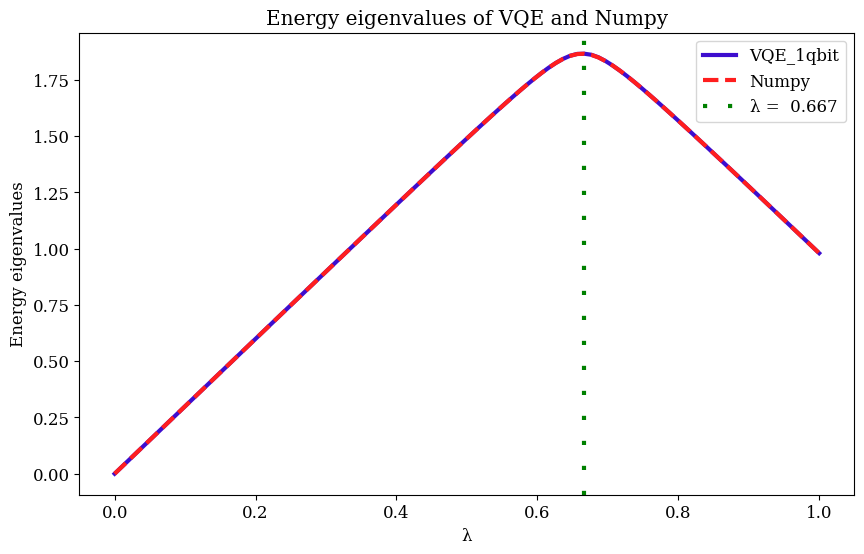

In [21]:
fig = plot_eigvals(result_1qbit)
plt.title('Energy eigenvalues of VQE and Numpy')
plt.savefig('figs/c_vqe_vs_numpy.pdf')
plt.savefig('selected_results/c_vqe_vs_numpy.pdf')
plt.show()

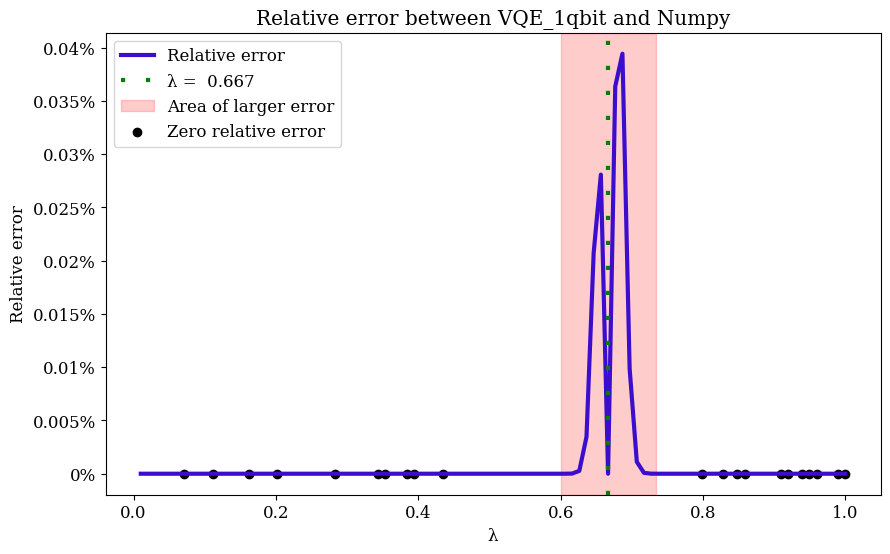

In [22]:
fig = plot_relative_error(result_1qbit)
plt.title('Relative error between VQE_1qbit and Numpy')
plt.savefig('figs/c_relative_error.pdf')
plt.show()

### <a id='toc6_2_1_'></a>[Error Analysis](#toc0_)

In [23]:
error_statistics(result_1qbit)

+----------+-------------+
| Metric   | Error (%)   |
+==========+=============+
| Mean     | 0.001%      |
| Median   | 3e-14%      |
| Max      | 0.04%       |
| Min      | 0%          |
| Std      | 0.006%      |
+----------+-------------+


## <a id='toc6_3_'></a>[Repeating the VQE calculation using qiskit's VQE algorithm](#toc0_)

Hamiltonian in terms of Pauli matrices:
$$
H_0 = \mathcal{E}I + Ωσ_z
$$  
with $\mathcal{E} = (E_1 + E_2)/2$ and $Ω = (E_1 - E_2)/2$.

$$
H_I = cI + ω_zσ_z + ω_xσ_x
$$
with $c = (V11 + V22)/2$, $ω_z = (V11 - V22)/2$ and $ω_x = V12 = V21$.

The total Hamiltonian is then:
$$
H = H_0 + λH_I
$$

### <a id='toc6_3_1_'></a>[Circuit](#toc0_)

In [24]:
from tqdm import tqdm 

def Hamiltonian_1qbit_circuit(λ: float) -> SparsePauliOp:
    """
    Creates a 1-qubit Hamiltonian in Qiskit's representation
    
    Parameters
    ----------
    λ : float
        Interaction strength
        
    Returns
    -------
    SparsePauliOp
        Hamiltonian as a sparse Pauli operator
    """
    # Parameters from Hamiltonian_1qbit
    E1, E2 = 0, 4
    E = (E1 + E2) / 2  # = 2
    Ω = (E1 - E2) / 2  # = -2
    
    V11 = 3
    V22 = -V11
    V12 = V21 = 0.2
    c   = (V11 + V22) / 2  # = 0
    ω_z = (V11 - V22) / 2  # = 3
    ω_x = V12  # = 0.2
    
    # Construct Hamiltonian terms
    # H = E*I + Ω*σ_z + λ*(c*I + ω_z*σ_z + ω_x*σ_x)
    # H = E*I + (Ω + λ*ω_z)*σ_z + λ*ω_x*σ_x
    
    hamiltonian = SparsePauliOp.from_list([
        ("I", E + λ*c),       # Identity term
        ("Z", Ω + λ*ω_z),     # Z term
        ("X", λ*ω_x)          # X term
    ])


    return hamiltonian

def create_ansatz_circuit() -> QuantumCircuit:
    """
    Creates a parameterized ansatz circuit for 1-qubit VQE
    
    Returns
    -------
    QuantumCircuit
        Parameterized quantum circuit
    """
    θ = Parameter('θ')
    φ = Parameter('φ')
    
    qc = QuantumCircuit(1)
    qc.rx(θ, 0)
    qc.ry(φ, 0)
    
    return qc

def run_vqe(λ: float) -> float:
    """
    Run VQE algorithm for a 1-qubit system
    
    Parameters
    ----------
    λ : float
        Interaction strength
        
    Returns
    -------
    float
        Ground state energy
    """
    # Create Hamiltonian
    hamiltonian = Hamiltonian_1qbit_circuit(λ)
    
    # Create ansatz circuit
    ansatz = create_ansatz_circuit()
    
    # Set up Gradient Descent optimizer
    optimizer = AQGD(maxiter=100)
    
    # Run VQE
    estimator = Estimator()
    vqe = VQE(estimator, ansatz, optimizer)
    result = vqe.compute_minimum_eigenvalue(hamiltonian)
    
    return result.eigenvalue.real

# Compare with exact solution
def compare_vqe_with_exact(λ_values):
    """
    Compare VQE results with exact diagonalization
    
    Parameters
    ----------
    λ_values : list or ndarray
        List of λ values to compute eigenvalues for
        
    Returns
    -------
    tuple
        (vqe_energies, exact_energies)
    """
    vqe_energies = []
    exact_energies = []
    
    for λ in tqdm(λ_values):
        # VQE solution
        vqe_energy = run_vqe(λ)
        vqe_energies.append(vqe_energy)
        
        # Exact solution using NumPyMinimumEigensolver
        hamiltonian = Hamiltonian_1qbit_circuit(λ)
        exact_solver = NumPyMinimumEigensolver()
        result = exact_solver.compute_minimum_eigenvalue(hamiltonian)
        exact_energies.append(result.eigenvalue.real)
        
    
    return vqe_energies, exact_energies

lambdas = np.linspace(0, 1, 100)
filterwarnings("ignore", category=DeprecationWarning) # Ignore DeprecationWarning for NumPyMinimumEigensolver
vqe_results, exact_results = compare_vqe_with_exact(lambdas)
filterwarnings("default", category=DeprecationWarning) # Turn warning back on

100%|██████████| 100/100 [00:12<00:00,  7.94it/s]


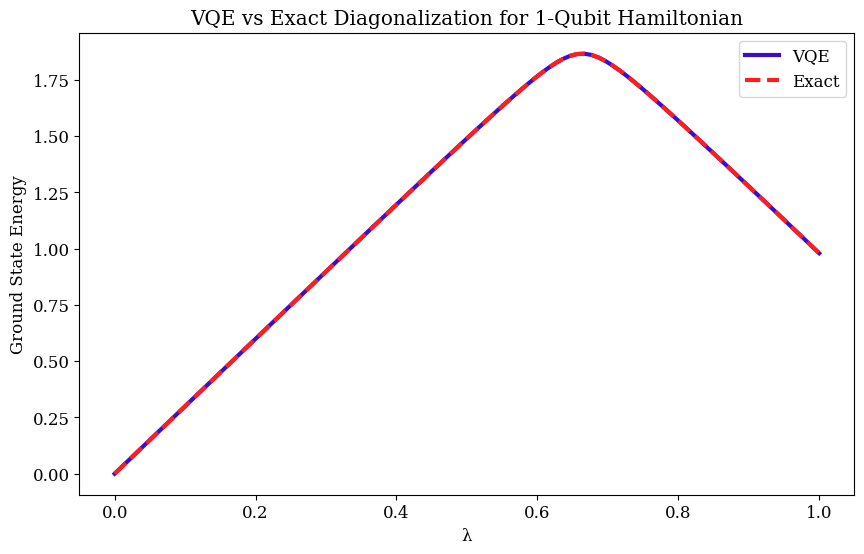

In [25]:
# Plot the results
plt.plot(lambdas, vqe_results, '-', label='VQE')
plt.plot(lambdas, exact_results, '--', label='Exact')
plt.xlabel('λ')
plt.ylabel('Ground State Energy')
plt.title('VQE vs Exact Diagonalization for 1-Qubit Hamiltonian')
plt.legend()
plt.savefig('figs/d_vqe_qiskit_vs_exact.pdf')
plt.savefig('selected_results/d_vqe_qiskit_vs_exact.pdf')
plt.show()

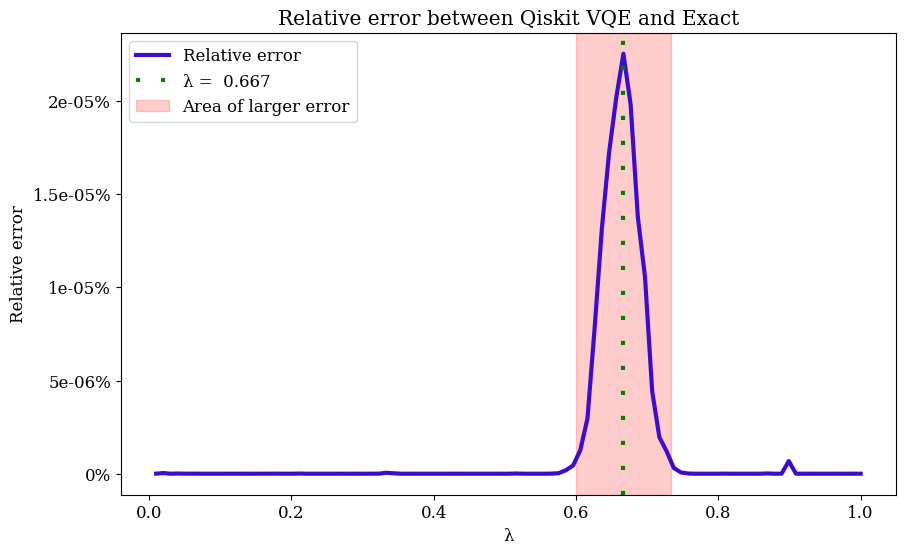

In [26]:
result_1qbit_qk = Benchmark_Results(np.array(vqe_results), np.array(exact_results), lambdas, 'VQE_Qiskit', 2/3)
fig = plot_relative_error(result_1qbit_qk)
plt.title('Relative error between Qiskit VQE and Exact')
plt.savefig('figs/d_relative_error.pdf')
plt.show()

In [27]:
error_statistics(result_1qbit_qk)

+----------+-------------+
| Metric   | Error (%)   |
+==========+=============+
| Mean     | 1e-06%      |
| Median   | 1e-09%      |
| Max      | 2e-05%      |
| Min      | 1e-12%      |
| Std      | 4e-06%      |
+----------+-------------+


## <a id='toc6_4_'></a>[Conclusion](#toc0_)
- As we can see, the VQE method is able to approximate the eigenvalues of the Hamiltonian matrix, with a relative error of $≈ 0.04\%$ with our own VQE implementation, and $≈ 0.00003\%$ with qiskit's VQE implementation. Qiskit was a lot slower than our implementation, but it was also more accurate.
- Larger error around the $λ = 2/3$ region. This makes sense as the energy eigenstates are close in energy, making it harder to distinguish between them.

# <a id='toc7_'></a>[d)](#toc0_)

## <a id='toc7_1_'></a>[Functions](#toc0_)

In [28]:

@njit
def Hamiltonian_2qbit(λ: float) -> Array4x4_c:
    '''
    Creates the Hamiltonian for a given interaction strength λ.
    
    Parameters
    ----------
        λ: float
            The interaction strength
    
    Returns
    -------
        H: Array4x4_c
            The complex 4x4 Hamiltonian matrix
    '''
    ε00, ε10, ε01, ε11 = 0.0, 2.5, 6.5, 7.0
    # np.diag not supported by numba
    H0: Array2x2 = np.array([[ε00, 0, 0, 0], 
                             [0, ε10, 0, 0], 
                             [0, 0, ε01, 0], 
                             [0, 0, 0, ε11]], dtype=complex128)
    Hx = 2 
    Hz = 3
    σ_x, σ_y, σ_z = pauli()
    HI: Array2x2 = tensor_prod(Hx*σ_x, σ_x) + tensor_prod(Hz*σ_z, σ_z)
    
    H:  Array2x2 = H0 + λ*HI
    
    return H

def density_matrix_groundstate(λ: float) -> Array4x4:
    '''
    Creates the density matrix of the lowest energy state
    
    Parameters
    ----------
        λ: float
            The interaction strength
    
    Returns
    -------
        ρ0: Array4x4
            The density matrix of the lowest energy state
    '''
    H = Hamiltonian_2qbit(λ)
    ψ_0: Array4D = np.linalg.eigh(H)[1][:, 0]
    
    ρ0: Array4x4 = np.outer(ψ_0, ψ_0.conj())
    return ρ0

def partial_trace(qubit: Indexing_2qbit, ρ: Array4x4) -> float:
    '''
    Partial trace over qubit
    
    Parameters
    ----------
        qubit: int
            Which qubit to trace over. Uses 0-based indexing
        ρ: Array4x4
            The density matrix
            
    Returns
    -------
        Tr(ρ_partial): float
            The partial trace of the density matrix
    '''
    q0, q1 = create_system_vectors(1)
    I_2 = np.eye(2)
    
    if qubit == 0:
        op0 = tensor_prod(q0, I_2)
        op1 = tensor_prod(q1, I_2)
    
    elif qubit == 1:
        op0 = tensor_prod(I_2, q0)
        op1 = tensor_prod(I_2, q1)
    
    else:
        raise ValueError('qubit must be 0 or 1')
    
    return op0.conj() @ ρ @ op0.T + op1.conj() @ ρ @ op1.T
    
    
def entropy(λ: float, ε: float = 1e-12) -> float:
    '''
    Calculates the entropy of the reduced density matrix
    
    Parameters
    ----------
        λ: float
            The interaction strength
        ε: float (optional)
            Small value to avoid log(0). Default is 1e-12
        
    Returns
    -------
        S: float
            The entropy of the reduced density matrix
    '''
    ρ0 = density_matrix_groundstate(λ)
    ρ_A = partial_trace(0, ρ0)
    S = -np.trace(ρ_A @ np.log2(ρ_A + ε))
    
    # Sanity check
    assert np.iscomplex(S) == False, f'Entropy is complex. Something went wrong: S = {S}, type(S) = {type(S)}'
    return S.real    

### <a id='toc7_1_1_'></a>[Analytical Solution](#toc0_)

#### <a id='toc7_1_1_1_'></a>[Using SymPy](#toc0_)

In [29]:
ε00, ε01, ε10, ε11 = sp.symbols('ε00 ε01 ε10 ε11')
λ = sp.symbols('λ')
Hx, Hz = sp.symbols('H_x H_z')
H = sp.Matrix([[ε00 + λ*Hz, 0         , 0         , λ*Hx],
               [0         , ε10 - λ*Hz, λ*Hx      , 0],
               [0         , λ*Hx      , ε01 - λ*Hz, 0],
               [λ*Hx      , 0         , 0         , ε11 + λ*Hz]])

# Sometimes finding the eigenvectors and values hangs.
# This usually takes 5 seconds (on my machine)
# If it takes longer, interrupt the cell and run it again
eigvecs_and_vals = H.eigenvects(simplify=True)
        
eigvals = [eigvec[0] for eigvec in eigvecs_and_vals]
eigvecs = [eigvec[2][0] for eigvec in eigvecs_and_vals]

In [30]:
Hx = 2 
Hz = 3
ε00, ε10, ε01, ε11 = 0, 2.5, 6.5, 7

# Evaluate eigenvalues at λ = 0
eigvals_at_lambda_0 = [eigval.subs({'Hx': Hx, 'Hz': Hz, 'ε00': ε00, 'ε10': ε10, 'ε01': ε01, 'ε11': ε11, 'λ': 0}) for eigval in eigvals]

# Sort eigenvectors by their respective eigenvalues at λ = 0
eigvecs = [eigvec for _, eigvec in sorted(zip(eigvals_at_lambda_0, eigvecs), key=lambda x: x[0])]


for i, (eigval, eigvec) in enumerate(zip(eigvals, eigvecs)):
    print(f'Eigenvalue {i}:')
    display(sp.simplify(eigval))
    print(f'Eigenvector {i}:')
    display(sp.simplify(eigvec))
    print('--'*24)
    print()

Eigenvalue 0:


-H_z*λ + ε01/2 + ε10/2 - sqrt(4*H_x**2*λ**2 + ε01**2 - 2*ε01*ε10 + ε10**2)/2

Eigenvector 0:


Matrix([
[(ε00 - ε11 - sqrt(4*H_x**2*λ**2 + ε00**2 - 2*ε00*ε11 + ε11**2))/(2*H_x*λ)],
[                                                                        0],
[                                                                        0],
[                                                                        1]])

------------------------------------------------

Eigenvalue 1:


-H_z*λ + ε01/2 + ε10/2 + sqrt(4*H_x**2*λ**2 + ε01**2 - 2*ε01*ε10 + ε10**2)/2

Eigenvector 1:


Matrix([
[                                                                         0],
[(-ε01 + ε10 - sqrt(4*H_x**2*λ**2 + ε01**2 - 2*ε01*ε10 + ε10**2))/(2*H_x*λ)],
[                                                                         1],
[                                                                         0]])

------------------------------------------------

Eigenvalue 2:


H_z*λ + ε00/2 + ε11/2 - sqrt(4*H_x**2*λ**2 + ε00**2 - 2*ε00*ε11 + ε11**2)/2

Eigenvector 2:


Matrix([
[                                                                         0],
[(-ε01 + ε10 + sqrt(4*H_x**2*λ**2 + ε01**2 - 2*ε01*ε10 + ε10**2))/(2*H_x*λ)],
[                                                                         1],
[                                                                         0]])

------------------------------------------------

Eigenvalue 3:


H_z*λ + ε00/2 + ε11/2 + sqrt(4*H_x**2*λ**2 + ε00**2 - 2*ε00*ε11 + ε11**2)/2

Eigenvector 3:


Matrix([
[(ε00 - ε11 + sqrt(4*H_x**2*λ**2 + ε00**2 - 2*ε00*ε11 + ε11**2))/(2*H_x*λ)],
[                                                                        0],
[                                                                        0],
[                                                                        1]])

------------------------------------------------



#### <a id='toc7_1_1_2_'></a>[Using the Results from Above](#toc0_)

In [31]:
def analytical_energy_eigenstates(λ: float) -> tuple[Array4D, Array4D, Array4D, Array4D]:
    '''
    Calculates the energy eigenstates of the Hamiltonian using the analytical solution
    
    Parameters
    ----------
        λ: float
            The interaction strength
    
    Returns
    -------
        eigenstates: tuple[Array4x4, Array4x4, Array4x4, Array4x4]
            The energy eigenstates. The order is the same as the energy eigenvalues in `energy_eigenvalues()`
    '''
    Hx = 2 
    Hz = 3
    ε00, ε10, ε01, ε11 = 0, 2.5, 6.5, 7
    q00, q01, q10, q11 = create_system_vectors(2)
    
    sqrt1 = np.sqrt(4*(Hx*λ)**2 + ε01**2 - 2*ε01*ε10 + ε10**2)
    sqrt2 = np.sqrt(4*(Hx*λ)**2 + ε00**2 - 2*ε00*ε11 + ε11**2)
    
    
    filterwarnings('ignore', category=RuntimeWarning) # Suppress RuntimeWarnings for the division by zero
    
    v0: Array4D_c = q00 * (ε00 - ε11 - sqrt2)/(2*Hx*λ) + \
                    q01 * 0 +                            \
                    q10 * 0 +                            \
                    q11 * 1
                    
    v1: Array4D_c = q00 * 0 +                            \
                    q01 * (ε10 - ε01 - sqrt1)/(2*Hx*λ) + \
                    q10 * 1 +                            \
                    q11 * 0

    v2: Array4D_c = q00 * 0 +                            \
                    q01 * (ε10 - ε01 + sqrt1)/(2*Hx*λ) + \
                    q10 * 1 +                            \
                    q11 * 0
                    

    v3: Array4D_c = q00 * (ε00 - ε11 + sqrt2)/(2*Hx*λ) + \
                    q01 * 0 +                            \
                    q10 * 0 +                            \
                    q11 * 1
    
    filterwarnings('default', category=RuntimeWarning) # Reset warnings
    
    # Normalizing the vectors
    v0: Array4D = v0 / np.linalg.norm(v0)
    v1: Array4D = v1 / np.linalg.norm(v1)
    v2: Array4D = v2 / np.linalg.norm(v2)
    v3: Array4D = v3 / np.linalg.norm(v3)
    
    return v0, v1, v2, v3


def analytical_energy_eigenvalues(λ: float) -> tuple[float, float, float, float]:
    '''
    Calculates the energy eigenvalues of the Hamiltonian using the analytical solution
    
    Parameters
    ----------
        λ: float
            The interaction strength
    
    Returns
    -------
        eigenvalues: tuple[float, float, float, float]
            The energy eigenvalues. The order is the same as the energy eigenstates in `energy_eigenstates()`
    '''
    Hx = 2 
    Hz = 3
    ε00, ε10, ε01, ε11 = 0, 2.5, 6.5, 7
    sqrt1 = np.sqrt(4*(Hx*λ)**2  + ε01**2 - 2*ε01*ε10 + ε10**2)
    sqrt2 = np.sqrt(4*Hx*Hz*λ**2 + ε00**2 - 2*ε00*ε11 + ε11**2)
    
    eigval_0 = 1/2 * (ε00 + ε11 - sqrt2 + 2*Hz*λ)
    eigval_1 = 1/2 * (ε01 + ε10 - sqrt1 - 2*Hz*λ)
    eigval_2 = 1/2 * (ε01 + ε10 + sqrt1 - 2*Hz*λ)
    eigval_3 = 1/2 * (ε00 + ε11 + sqrt2 + 2*Hz*λ)
        
    return eigval_0, eigval_1, eigval_2, eigval_3


def entropy_state(state: Literal[0, 1, 2, 3], λ: float, ε: float = 1e-12) -> float:
    '''
    Calculates the entropy for a given energy eigenstate 
    
    Parameters
    ----------
        state: int
            The state to find the entropy of. Uses 0-based indexing
        λ: float
            The interaction strengths
        ε: float (optional)
            Small value to avoid log(0). Default is 1e-12
    Returns
    -------
        S: float
            The entropy of the reduced density matrix for the original ground state
    '''
    
    ψ: Array4D  = analytical_energy_eigenstates(λ)[state]
    ρ: Array4x4 = np.outer(ψ, ψ.conj())
    
    ρ_A = partial_trace(0, ρ) # Does not matter which qubit we trace over
    S = -np.trace(ρ_A @ np.log2(ρ_A + ε))
    
    # Sanity check
    assert np.iscomplex(S) == False, f'Entropy is complex. Something went wrong: S = {S}, type(S) = {type(S)}'
    return S.real        

## <a id='toc7_2_'></a>[Plotting Energy and Entropy](#toc0_)

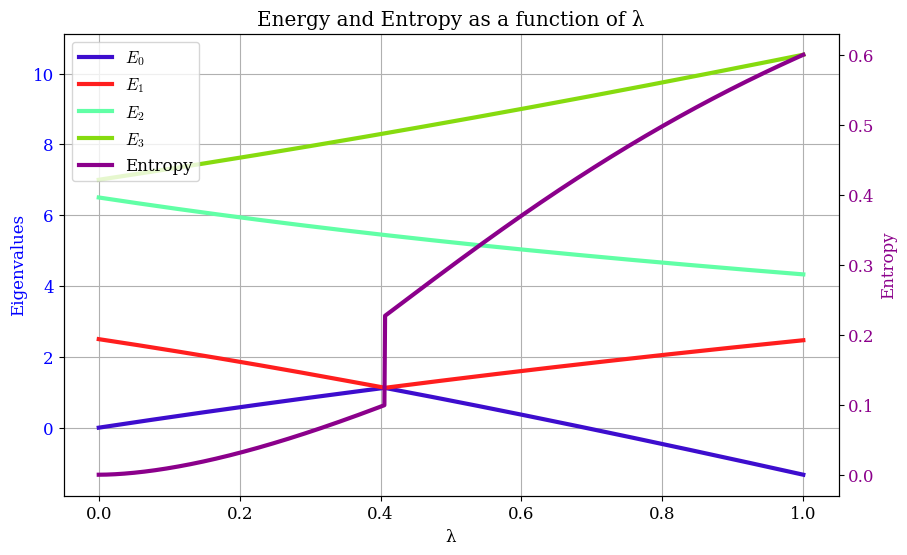

In [32]:
n_lambdas = 1000
lambdas = np.linspace(0, 1, n_lambdas)
energy_eigvals = [np.linalg.eigvalsh(Hamiltonian_2qbit(λ)) for λ in lambdas]
entropies = [entropy(λ) for λ in lambdas]

plt.plot(lambdas, energy_eigvals, label=['$E_0$', '$E_1$', '$E_2$', '$E_3$'])
lines_energy, labels_energy = plt.gca().get_legend_handles_labels()
plt.xlabel('λ')
plt.ylabel('Eigenvalues', color='blue')
plt.yticks(color='blue')
plt.grid()

plt.twinx()

plt.plot(lambdas, entropies, color='darkmagenta', label='Entropy')
lines_entropy, labels_entropy = plt.gca().get_legend_handles_labels()
plt.ylabel('Entropy', color='darkmagenta')
plt.yticks(color='darkmagenta')
plt.title('Energy and Entropy as a function of λ')
plt.legend(lines_energy + lines_entropy, labels_energy + labels_entropy)
plt.savefig('figs/d_energy_entropy.pdf')
plt.savefig('selected_results/d_energy_entropy.pdf')
plt.show()

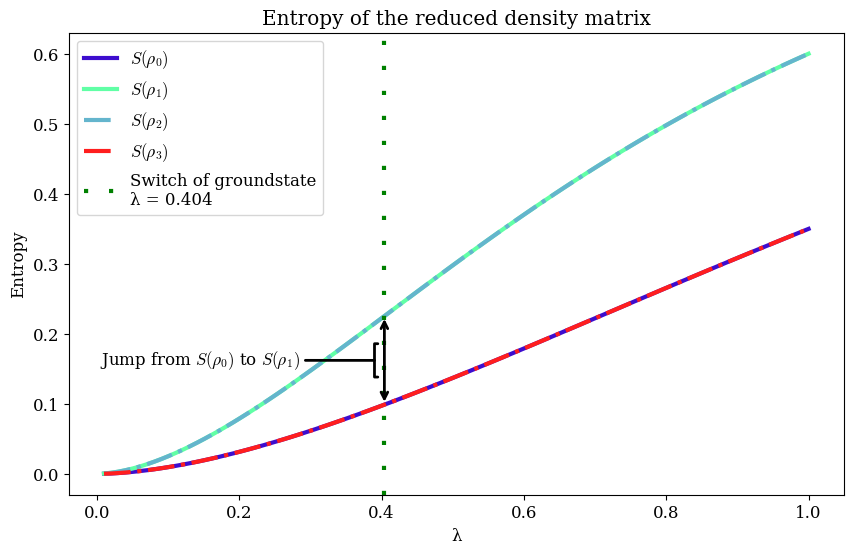

In [33]:
n_lambdas = 100
lambdas = np.linspace(0, 1, n_lambdas)

entropy_0 = [entropy_state(0, λ) for λ in lambdas]
entropy_1 = [entropy_state(1, λ) for λ in lambdas]
entropy_2 = [entropy_state(2, λ) for λ in lambdas]
entropy_3 = [entropy_state(3, λ) for λ in lambdas]

energy_eigvals = np.array([np.linalg.eigvalsh(Hamiltonian_2qbit(λ)).real for λ in lambdas])

E0 = energy_eigvals[:, 0]
E1 = energy_eigvals[:, 1]

switch_point_idx = np.argmin(np.abs(E0 - E1))
gap = entropy_2[switch_point_idx] - entropy_0[switch_point_idx]

plt.plot(lambdas, entropy_0, label=r'$S(ρ_0)$', linewidth = 3, linestyle='-')
plt.plot(lambdas, entropy_1, label=r'$S(ρ_1)$', linewidth = 3, linestyle='-', color='C2')
plt.plot(lambdas, entropy_2, label=r'$S(ρ_2)$', linewidth = 3, linestyle='-.', color='C5')
plt.plot(lambdas, entropy_3, label=r'$S(ρ_3)$', linewidth = 3, linestyle='-.', color='C1')
plt.axvline(x=lambdas[switch_point_idx], color='green', linestyle=(0, (1, 5)), label=f'Switch of groundstate\nλ = {lambdas[switch_point_idx]:.3f}')
plt.ylabel('Entropy')
plt.xlabel('λ')
plt.title('Entropy of the reduced density matrix')

plt.annotate(text="",
             xy=(lambdas[switch_point_idx], entropy_0[switch_point_idx]),
             xytext=(lambdas[switch_point_idx], entropy_0[switch_point_idx] + gap),
             arrowprops=dict(arrowstyle='<->', lw=2)
            )

plt.annotate(text="Jump from $S(ρ_0)$ to $S(ρ_1)$",
             xy=(lambdas[switch_point_idx]-.01, entropy_0[switch_point_idx] + gap/2),
             xytext=(lambdas[switch_point_idx] - 0.4, entropy_0[switch_point_idx] + gap/2*0.9),
             arrowprops=dict(arrowstyle='-[', lw=2)
            )

plt.legend()
plt.savefig('figs/d_entropy.pdf')
plt.show()

## <a id='toc7_3_'></a>[Conclusion](#toc0_)
- As the interaction strength $λ$ increases, we see a switch in which the lowest energy state switches from $|ψ_{0}⟩$ with corresponding eigenvalue $E_0$, to $|ψ_{1}⟩$ with corresponding eigenvalue $E_1$. 
- When calculating the entropy, we always look at the lowest energy state. After the switch from $|ψ_{0}⟩$ to $|ψ_{1}⟩$, we switch what state we calculate the entropy from. As these two states have different entropies, the entropy makes a sudden jump at the point of the switch.

# <a id='toc8_'></a>[e)](#toc0_)

## <a id='toc8_1_'></a>[Functions](#toc0_)

In [34]:
@njit
def Energy_2qbit(θ1: float, θ2: float, θ3: float, θ4: float, λ: float) -> float:
    '''
    Calculates the energy eigenvalues of the Hamiltonian for a 2-qubit system
    
    Parameters
    ----------
        θ1: float
            The angle (radians) to rotate by around the x-axis of qubit 0
        θ2: float
            The angle (radians) to rotate by around the y-axis of qubit 0
        θ3: float
            The angle (radians) to rotate by around the x-axis of qubit 1
        θ4: float
            The angle (radians) to rotate by around the y-axis of qubit 1
        λ: float
            The interaction strength
    
    Returns
    -------
        E: float
            The energy eigenvalue (real part)
    '''
    R1:   Array2x2_c = Rx(θ1) @ Ry(θ2)
    R2:   Array2x2_c = Rx(θ3) @ Ry(θ4)
    CNOT: Array4x4_c = cnot()
    
    basis = np.array([1, 0, 0, 0], dtype=complex128) # |00⟩: Will be rotated anyways so no need to use |01⟩, |10⟩ or |11⟩
    rotated_basis: Array4x4_c = CNOT @ tensor_prod(R1, R2) @ basis
    E = rotated_basis.conj().T @ Hamiltonian_2qbit(λ) @ rotated_basis
    
    assert abs(E.imag) < 1e-14  , f'Energy is complex. Something went wrong: E = {E}, type(E) = {type(E)}'
    return E.real

@njit
def VQE_2qbit(N: int, η: float, λ: float = 0, seed: int = 2024) -> float:
    '''
    Variational Quantum Eigensolver using Gradient Descent to find the minimum energy
    
    Parameters
    ----------
        N: int
            Number of iterations
        η: float
            Learning rate
        λ: float
            Interaction strength of the Hamiltonian
        seed: int
            Seed for the random number generator
            
    Returns
    -------
        Energy(θ1, θ2, θ3, θ4, λ): float
            The energy eigenvalue (real part)
    '''
    π = np.pi
    np.random.seed(seed)
    θ1 = 2*π*np.random.rand()
    θ2 = 2*π*np.random.rand()
    θ3 = 2*π*np.random.rand()
    θ4 = 2*π*np.random.rand()
    
    # More compact to rename function
    E: Callable = Energy_2qbit
    for _ in range(N):
        ΔE_Δθ1 = (E(θ1+π/2, θ2, θ3, θ4, λ) - E(θ1-π/2, θ2, θ3, θ4, λ)) / 2
        ΔE_Δθ2 = (E(θ1, θ2+π/2, θ3, θ4, λ) - E(θ1, θ2-π/2, θ3, θ4, λ)) / 2
        ΔE_Δθ3 = (E(θ1, θ2, θ3+π/2, θ4, λ) - E(θ1, θ2, θ3-π/2, θ4, λ)) / 2
        ΔE_Δθ4 = (E(θ1, θ2, θ3, θ4+π/2, λ) - E(θ1, θ2, θ3, θ4-π/2, λ)) / 2
        
        θ1 -= η * ΔE_Δθ1
        θ2 -= η * ΔE_Δθ2
        θ3 -= η * ΔE_Δθ3
        θ4 -= η * ΔE_Δθ4
    
    # Using the actual function name
    E = Energy_2qbit(θ1, θ2, θ3, θ4, λ)
    return E

## <a id='toc8_2_'></a>[Comparing VQE and Exact Eigenvalues](#toc0_)

In [35]:
n_iterations = 400
η = 1/4
n_lambdas = 100
lambdas = np.linspace(0, 1, n_lambdas)

result_2qbit: Benchmark_Results = benchmark_VQE(VQE_2qbit, Hamiltonian_2qbit, n_iterations, η, lambdas)

energy_eigvals = np.array([analytical_energy_eigenvalues(λ) for λ in lambdas])
E0 = energy_eigvals[:, 0]
E1 = energy_eigvals[:, 1]

switch_point_idx = np.argmin(np.abs(E0 - E1))
switch_point = lambdas[switch_point_idx]

result_2qbit.switch_point = switch_point

+------------------+------------+---------------------------+
| Method           |   Time (s) |   Times Slower than Numpy |
+==================+============+===========================+
| VQE_2qbit (cold) |     2.7    |                   1951.89 |
+------------------+------------+---------------------------+
| VQE_2qbit (warm) |     1.4    |                   1037.72 |
+------------------+------------+---------------------------+
| Numpy            |     0.0014 |                      1    |
+------------------+------------+---------------------------+


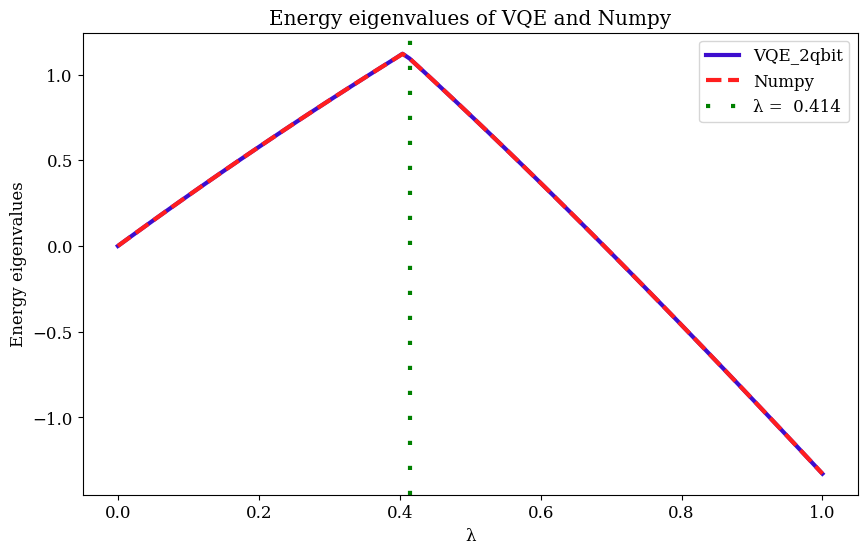

In [36]:
fig = plot_eigvals(result_2qbit)
plt.title('Energy eigenvalues of VQE and Numpy')
plt.savefig('figs/e_vqe_vs_numpy.pdf')
plt.savefig('selected_results/e_vqe_vs_numpy.pdf')
plt.show()

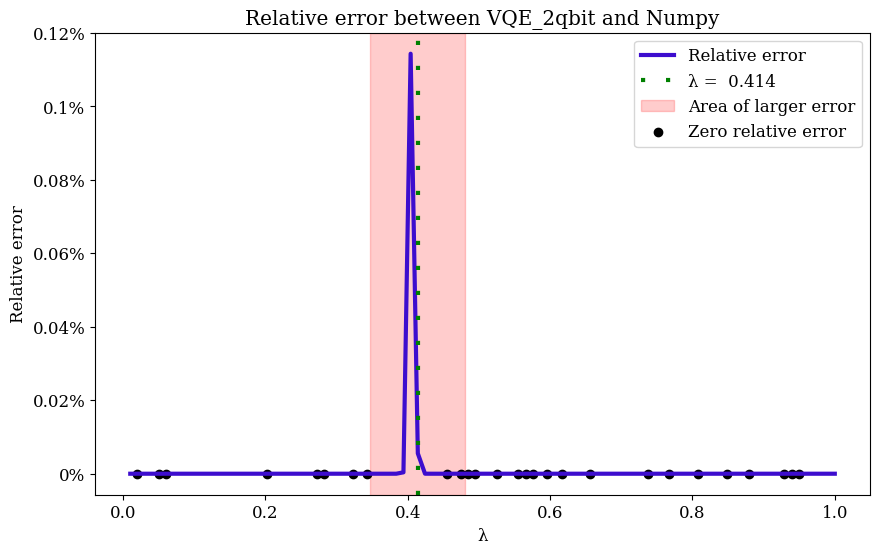

In [37]:
fig = plot_relative_error(result_2qbit)
plt.title('Relative error between VQE_2qbit and Numpy')
plt.savefig('figs/e_relative_error.pdf')
plt.show()

### <a id='toc8_2_1_'></a>[Error Analysis](#toc0_)

In [38]:
error_statistics(result_2qbit)

+----------+-------------+
| Metric   | Error (%)   |
+==========+=============+
| Mean     | 0.001%      |
| Median   | 2e-14%      |
| Max      | 0.1%        |
| Min      | 0%          |
| Std      | 0.01%       |
+----------+-------------+


In [39]:
def hamiltonian_2qbit_qiskit(λ: float) -> SparsePauliOp:
    """
    Express the 2-qubit Hamiltonian as a sum of Pauli operators for Qiskit
    
    Parameters
    ----------
    λ : float
        Interaction strength
        
    Returns
    -------
    SparsePauliOp
        Hamiltonian as Pauli operators
    """
    # Parameters from Hamiltonian_2qbit
    ε00, ε10, ε01, ε11 = 0.0, 2.5, 6.5, 7.0
    Hx = 2
    Hz = 3
    
    # Express H0 (diagonal matrix) in terms of Pauli operators
    # For a 2-qubit system, we use II, IZ, ZI, ZZ to represent diagonal matrices
    
    # Calculate coefficients
    c_II = (ε00 + ε10 + ε01 + ε11) / 4  # Coefficient of II
    c_IZ = (ε00 + ε10 - ε01 - ε11) / 4  # Coefficient of IZ
    c_ZI = (ε00 - ε10 + ε01 - ε11) / 4  # Coefficient of ZI
    c_ZZ = (ε00 - ε10 - ε01 + ε11) / 4  # Coefficient of ZZ
    
    # Interaction term: λ * (Hx * XX + Hz * ZZ)
    c_XX = λ * Hx  # Coefficient of XX
    c_ZZ_interaction = λ * Hz  # Additional ZZ term from interaction
    
    # Combine ZZ terms
    c_ZZ_total = c_ZZ + c_ZZ_interaction
    
    # Create the Hamiltonian as a SparsePauliOp
    hamiltonian = SparsePauliOp.from_list([
        ('II', c_II),
        ('IZ', c_IZ),
        ('ZI', c_ZI),
        ('ZZ', c_ZZ_total),
        ('XX', c_XX)
    ])
    
    return hamiltonian

def create_2qubit_ansatz() -> QuantumCircuit:
    """
    Create a parameterized ansatz for 2-qubit VQE
    Replicating the structure used in Energy_2qbit
    
    Returns
    -------
    QuantumCircuit
        Parameterized quantum circuit
    """
    # Define parameters
    θ1 = Parameter('θ1')
    θ2 = Parameter('θ2')
    θ3 = Parameter('θ3')
    θ4 = Parameter('θ4')
    
    # Create circuit
    qc = QuantumCircuit(2)
    
    # Apply Rx and Ry gates to each qubit
    qc.rx(θ1, 0)
    qc.ry(θ2, 0)
    qc.rx(θ3, 1)
    qc.ry(θ4, 1)
    
    # Apply CNOT gate
    qc.cx(0, 1)
    
    return qc

def run_2qubit_vqe(λ: float, max_iterations: int = 10_00) -> float:
    """
    Run VQE for the 2-qubit system with given interaction strength λ
    
    Parameters
    ----------
    λ : float
        Interaction strength
    max_iterations : int, optional
        Maximum number of optimizer iterations, by default 100
        
    Returns
    -------
    float
        Ground state energy
    """
    # Create Hamiltonian
    hamiltonian = hamiltonian_2qbit_qiskit(λ)
    
    # Create ansatz
    ansatz = create_2qubit_ansatz()
    
    # Set up optimizer
    optimizer = COBYLA(maxiter=max_iterations)
    
    # Create estimator
    estimator = Estimator()
    
    # Run VQE
    vqe = VQE(estimator, ansatz, optimizer)
    result = vqe.compute_minimum_eigenvalue(hamiltonian)
    
    return result.eigenvalue.real

def compare_vqe_exact(λ_values):
    """
    Compare VQE results with exact diagonalization for range of λ values
    
    Parameters
    ----------
    λ_values : list or array
        List of λ values to evaluate
        
    Returns
    -------
    tuple
        (vqe_energies, exact_energies)
    """
    vqe_energies = []
    exact_energies = []
    
    for λ in tqdm(λ_values):
        # Run VQE
        vqe_energy = run_2qubit_vqe(λ)
        vqe_energies.append(vqe_energy)
        
        # Run exact diagonalization
        hamiltonian = hamiltonian_2qbit_qiskit(λ)
        exact_solver = NumPyMinimumEigensolver()
        result = exact_solver.compute_minimum_eigenvalue(hamiltonian)
        exact_energies.append(result.eigenvalue.real)
    
    return vqe_energies, exact_energies

# Example usage:
λ_values = np.linspace(0, 1, 100)
filterwarnings("ignore", category=DeprecationWarning) # Ignore DeprecationWarning for NumPyMinimumEigensolver
vqe_results, exact_results = compare_vqe_exact(λ_values)
filterwarnings("default", category=DeprecationWarning) # Turn warning back on

result_2qbit_qk = Benchmark_Results(np.array(vqe_results), np.array(exact_results), λ_values, 'VQE_Qiskit', switch_point)

100%|██████████| 100/100 [00:20<00:00,  4.88it/s]


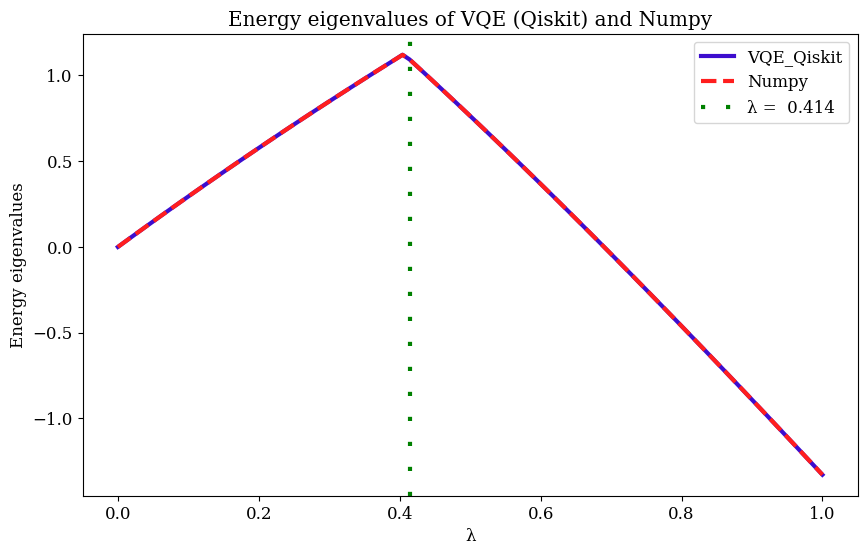

In [40]:
fig = plot_eigvals(result_2qbit_qk)
plt.title('Energy eigenvalues of VQE (Qiskit) and Numpy')
plt.savefig('figs/e_vqe_qiskit_vs_exact.pdf')
plt.savefig('selected_results/e_vqe_qiskit_vs_exact.pdf')
plt.show()

In [41]:
error_statistics(result_2qbit_qk)

+----------+-------------+
| Metric   | Error (%)   |
+==========+=============+
| Mean     | 1e+71%      |
| Median   | 3e-06%      |
| Max      | 1e+73%      |
| Min      | 3e-07%      |
| Std      | 1e+72%      |
+----------+-------------+


## <a id='toc8_3_'></a>[Conclusion](#toc0_)
- The VQE method was 1000-2000 times slower than using numpy, as opposed to 50-80 times slower in the 1 qubit case. 
    - This might not be surprising as one needs to preform the gradient descent which can't be done in parallel
    - The 2 qubit case involves twice as large matrices and vectors.   
- There was about one order of magnitude difference in the performance of the VQE method between the 1 and 2 qubit case, compared to using numpy.
- The algorithm could be improved by doing more iterations if the interaction strength $λ$ is near the point where the eigenvalues switch. This is done in the qiskit implementation. 

# <a id='toc9_'></a>[f)](#toc0_)

## <a id='toc9_1_'></a>[Defining the Hamiltonian for $J = 1$](#toc0_)

We first look at how the quasispin operators act on a state on a state $\ket{j, m_j}$:
$$
\begin{align*}
    J_+ \ket{j, m_j} &= \sqrt{j(j+1) - m_j(m_j+1)} \ket{j, m_j+1} \\
    J_- \ket{j, m_j} &= \sqrt{j(j+1) - m_j(m_j-1)} \ket{j, m_j-1} \\
    J_z \ket{j, m_j} &= m_j \ket{j, m_j}
\end{align*}
$$

We then write then write out the possible combinations of $m_j$ values for $J = 1$ as a matrix: 
$$
J_z = \begin{pmatrix}
    \bra{1,-1}J_z\ket{1, -1} & \bra{1,-1}J_z\ket{1,0} & \bra{1,-1}J_z\ket{1,1} \\
    \bra{1,0}J_z\ket{1, -1} & \bra{1,0}J_z\ket{1,0} & \bra{1,0}J_z\ket{1,1} \\
    \bra{1,1}J_z\ket{1, -1} & \bra{1,1}J_z\ket{1,0} & \bra{1,1}J_z\ket{1,1} \\
\end{pmatrix}
$$

With an orthonormal basis, we are guaranteed that the matrix is diagonal. Knowing $J_z \ket{1,0} = 0$, we get the final expression:
$$
J_z = \begin{pmatrix}
    -ℏ & 0 & 0 \\
    0 & 0 & 0 \\
    0 & 0 & ℏ \\
\end{pmatrix}
$$

We do the same for the $J_{+}^2$:
$$
J_{+}^2 = \begin{pmatrix}
    \bra{1,-1}J_{+}^2\ket{1, -1} & \bra{1,-1}J_{+}^2\ket{1,0} & \bra{1,-1}J_{+}^2\ket{1,1} \\
    \bra{1,0}J_{+}^2\ket{1, -1} & \bra{1,0}J_{+}^2\ket{1,0} & \bra{1,0}J_{+}^2\ket{1,1} \\
    \bra{1,1}J_{+}^2\ket{1, -1} & \bra{1,1}J_{+}^2\ket{1,0} & \bra{1,1}J_{+}^2\ket{1,1} \\
\end{pmatrix}
$$

Which results in:
$$
J_{+}^2 = \begin{pmatrix}
    0 & 0 & 2ℏ \\
    0 & 0 & 0 \\
    0 & 0 & 0 \\
\end{pmatrix}
$$

And at last for $J_{-}^2$:
$$
J_{-}^2 = \begin{pmatrix}
    \bra{1,-1}J_{-}^2\ket{1, -1} & \bra{1,-1}J_{-}^2\ket{1,0} & \bra{1,-1}J_{-}^2\ket{1,1} \\
    \bra{1, 0}J_{-}^2\ket{1, -1} & \bra{1,0}J_{-}^2\ket{1,0}  & \bra{1, 0}J_{-}^2\ket{1,1} \\
    \bra{1, 1}J_{-}^2\ket{1, -1} & \bra{1,1}J_{-}^2\ket{1,0}  & \bra{1, 1}J_{-}^2\ket{1,1} \\
\end{pmatrix}
$$

Which results in:
$$
J_{-}^2 = \begin{pmatrix}
    0  & 0 & 0 \\
    0  & 0 & 0 \\
    2ℏ & 0 & 0 \\
\end{pmatrix}
$$

We define $ℏ = 1$ and using $H_0 = ϵJ_z$ and $H_1 = -V\left(J_{+}^2 + J_{-}^2\right)/2$, we get the Hamiltonian matrix for $J = 1$:
$$
H = \begin{pmatrix}
    -ϵ & 0 & -V \\
    0  & 0 &  0 \\
    -V & 0 &  ϵ \\
\end{pmatrix}
$$

## <a id='toc9_2_'></a>[Rewriting the $J = 1$ Hamiltonian with Pauli Matrices](#toc0_)

In [42]:
filterwarnings("ignore", category=ComplexWarning)
X, _, Z = map(np.astype, pauli(), [int, complex128, int]) # Convert to int for pretty printing
filterwarnings("default", category=ComplexWarning)

I_2 = sp.Identity(2)

ZZ = tensor_prod(Z, Z)
ZI = tensor_prod(Z, I_2)
XI = tensor_prod(X, I_2)
XZ = tensor_prod(X, Z)

ϵ = sp.symbols('ϵ')
V = sp.symbols('V')
H = ϵ/2 * (ZI + ZZ) + V/2 * (XI + XZ)
H = sp.simplify(H)

print('Hamiltonian:')
display(H)

Hamiltonian:


[[ϵ, 0, V, 0], [0, 0, 0, 0], [V, 0, -ϵ, 0], [0, 0, 0, 0]]

## <a id='toc9_3_'></a>[Rewriting the $J = 2$ Hamiltonian with Pauli Matrices](#toc0_)
We use block diagonalization to write our Hamiltonian using Pauli matrices:
$$
H = \begin{pmatrix}
    H_1 &  \\
     & H_2
\end{pmatrix}
$$

Where $H_1$ have dimensions $4 \times 4$ and $H_2$ have dimensions $2 \times 2$. The code below implements and verifies the Hamiltonian being as expected. They will not look identical, but the lowest eigenvalues is the same, which is what we need

In [43]:
def Block4x4(ϵ: float, V: float) -> Array4x4_c:
    '''
    Creates the first block of the Hamiltonian
    
    Parameters
    ----------
        ϵ: float
            The coupling strength
        V: float
            The interaction strength
    
    Returns
    -------
        H: Array4x4_c
            The complex 4x4 block of the Hamiltonian 
    '''
    X, Y, Z = pauli()
    I_2 = np.eye(2)
    
    IX = tensor_prod(I_2, X)
    XX = tensor_prod(X, X)

    YY = tensor_prod(Y, Y)

    ZI = tensor_prod(Z, I_2)
    ZZ = tensor_prod(Z, Z)
    ZX = tensor_prod(Z, X)
    
    sqrt6 = np.sqrt(6)
    H = -ϵ * (ZI + ZZ) + sqrt6*V/2 * (IX + XX + YY + ZX)
    return H

def Block2x2(ϵ: float, V: float) -> Array2x2_c:
    '''
    Creates the second block of the Hamiltonian
    
    Parameters
    ----------
        ϵ: float
            The coupling strength
        V: float
            The interaction strength
    
    Returns
    -------
        H: Array2x2_c
            The complex 2x2 block of the Hamiltonian 
    '''
    X, _, Z = pauli()
    
    H = -ϵ*Z + 3*V*X 
    return H

def Hamiltonian_Lipkin(ϵ: float, V: float) -> Array5x5_c:
    '''
    Creates the Hamiltonian for the Lipkin model
    
    Parameters
    ----------
        ϵ: float
            The coupling strength
        V: float
            The interaction strength
    
    Returns
    -------
        H: Array5x5_c
            The complex 5x5 Hamiltonian matrix
    '''
    H1 = Block4x4(ϵ, V)
    H2 = Block2x2(ϵ, V)
    
    H = np.zeros((5, 5), dtype=complex128)
    H[:4, :4] = H1
    H[3:, 3:] = H2
    
    return H

In [44]:
# Create symbolic representation of the Lipkin model Hamiltonian
ϵ = sp.symbols('ϵ', real=True)
V = sp.symbols('V', real=True)

sqrt6 = sp.sqrt(6)
H_standard = sp.Matrix([[   -2*ϵ,   0, sqrt6*V,   0,       0],
                        [      0,  -ε,       0, 3*V,       0],
                        [sqrt6*V,   0,       0,   0, sqrt6*V],
                        [      0, 3*V,       0,   ϵ,       0],
                        [      0,   0, sqrt6*V,   0,     2*ϵ]])

# Define Pauli matrices symbolically
σ_x = sp.Matrix([[0, 1], [1, 0]])
σ_y = sp.Matrix([[0, -sp.I], [sp.I, 0]])
σ_z = sp.Matrix([[1, 0], [0, -1]])
I_2 = sp.eye(2)

# Create symbolic blocks for the Hamiltonian
# First block (4x4)
IX = sp.kronecker_product(I_2, σ_x)
XX = sp.kronecker_product(σ_x, σ_x)
YY = sp.kronecker_product(σ_y, σ_y)
ZI = sp.kronecker_product(σ_z, I_2)
ZZ = sp.kronecker_product(σ_z, σ_z)
ZX = sp.kronecker_product(σ_z, σ_x)

H1 = -ϵ * (ZI + ZZ) + sqrt6*V/2 * (IX + XX + YY + ZX)

# Second block (2x2)
H2 = -ϵ*σ_z + 3*V*σ_x

# Create the full 5x5 Hamiltonian
H_lipkin = sp.zeros(5, 5)
H_lipkin[:4, :4] = H1
H_lipkin[3:, 3:] = H2

print("Standard Lipkin Model Hamiltonian:")
display(H_standard)
print() 
print("Block Diagonalized Lipkin Model Hamiltonian:")
display(H_lipkin)

Standard Lipkin Model Hamiltonian:


Matrix([
[     -2*ϵ,   0, sqrt(6)*V,   0,         0],
[        0,  -ϵ,         0, 3*V,         0],
[sqrt(6)*V,   0,         0,   0, sqrt(6)*V],
[        0, 3*V,         0,   ϵ,         0],
[        0,   0, sqrt(6)*V,   0,       2*ϵ]])


Block Diagonalized Lipkin Model Hamiltonian:


Matrix([
[     -2*ϵ, sqrt(6)*V,         0,   0,   0],
[sqrt(6)*V,         0, sqrt(6)*V,   0,   0],
[        0, sqrt(6)*V,       2*ϵ,   0,   0],
[        0,         0,         0,  -ϵ, 3*V],
[        0,         0,         0, 3*V,   ϵ]])

In [45]:
n = 100
ϵ = 1
V = np.linspace(0, 2, n)

eigevalues = []
for v in V:
    H = Hamiltonian_Lipkin(ϵ, v)
    eigevalues.append(np.linalg.eigvalsh(H))

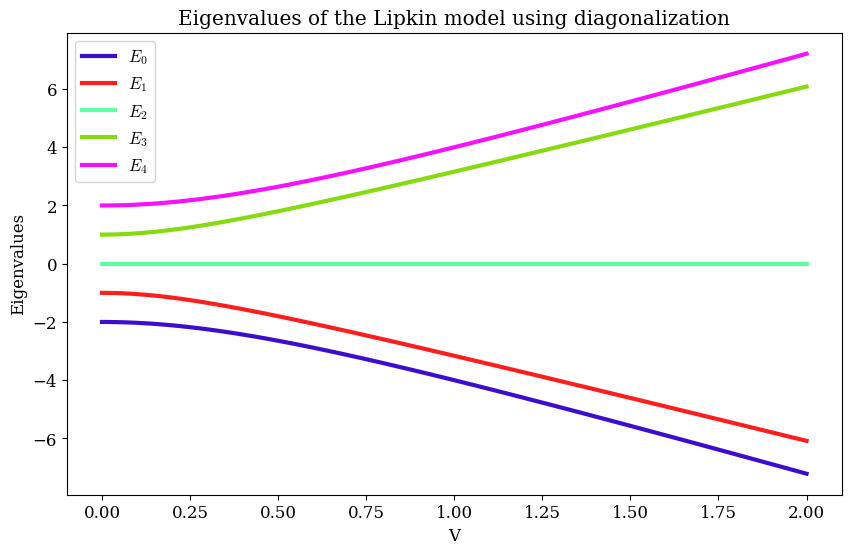

In [46]:
plt.plot(V, eigevalues, label=['$E_0$', '$E_1$', '$E_2$', '$E_3$', '$E_4$'])
plt.xlabel('V')
plt.ylabel('Eigenvalues')
plt.title('Eigenvalues of the Lipkin model using diagonalization')
plt.legend()
plt.savefig('figs/f_lipkin_eigenvalues_classical.pdf')
plt.savefig('selected_results/f_lipkin_eigenvalues_classical.pdf')
plt.show()

# <a id='toc10_'></a>[g)](#toc0_)

In [47]:
def lipkin_hamiltonian_1qubit(ϵ: float, V: float) -> SparsePauliOp:
    """
    Creates the 1-qubit Lipkin Hamiltonian for VQE
    
    Parameters
    ----------
    ϵ : float
        Coupling strength
    V : float
        Interaction strength
        
    Returns
    -------
    SparsePauliOp
        Hamiltonian as a sparse Pauli operator
    """
    # Using the Block2x2 Hamiltonian: H = -ϵ*Z + 3*V*X
    hamiltonian = SparsePauliOp.from_list([
        ('Z', -ϵ),      # -ϵ*Z term
        ('X', 3*V)      # 3*V*X term
    ])
    
    return hamiltonian

def create_1qubit_ansatz() -> QuantumCircuit:
    """
    Creates a parameterized ansatz circuit for 1-qubit VQE
    
    Returns
    -------
    QuantumCircuit
        Parameterized quantum circuit
    """
    θ = Parameter('θ')
    φ = Parameter('φ')
    
    qc = QuantumCircuit(1)
    qc.rx(θ, 0)
    qc.ry(φ, 0)
    
    return qc

def run_lipkin_vqe(ϵ: float, V: float, max_iterations: int = 10_000) -> float:
    """
    Runs VQE for the 1-qubit Lipkin model
    
    Parameters
    ----------
    ϵ : float
        Coupling strength
    V : float
        Interaction strength
    max_iterations : int, optional
        Maximum optimizer iterations, by default 100
        
    Returns
    -------
    float
        Ground state energy
    """
    # Create Hamiltonian
    hamiltonian = lipkin_hamiltonian_1qubit(ϵ, V)
    
    # Create ansatz
    ansatz = create_1qubit_ansatz()
    
    # Set up optimizer
    optimizer = COBYLA(maxiter=max_iterations)
    
    # Run VQE
    estimator = Estimator()
    vqe = VQE(estimator, ansatz, optimizer)
    result = vqe.compute_minimum_eigenvalue(hamiltonian)
    
    return result.eigenvalue.real

# Compare with exact solution across a range of V values
def compare_lipkin_vqe_exact(ϵ: float, V_values: np.ndarray):
    """
    Compare VQE with exact diagonalization for range of V values
    
    Parameters
    ----------
    ϵ : float
        Coupling strength
    V_values : np.ndarray
        Array of interaction strengths to evaluate
        
    Returns
    -------
    tuple
        (vqe_energies, exact_energies)
    """
    vqe_energies = []
    exact_energies = []
    
    for V in tqdm(V_values):
        # VQE solution
        vqe_energy = run_lipkin_vqe(ϵ, V)
        vqe_energies.append(vqe_energy)
        
        # Exact solution using NumPyMinimumEigensolver
        hamiltonian = lipkin_hamiltonian_1qubit(ϵ, V)
        exact_solver = NumPyMinimumEigensolver()
        result = exact_solver.compute_minimum_eigenvalue(hamiltonian)
        exact_energies.append(result.eigenvalue.real)
    
    return vqe_energies, exact_energies

# Example usage:
ϵ = 1.0
V_values = np.linspace(0, 2, 100)
filterwarnings("ignore", category=DeprecationWarning) # Ignore DeprecationWarning for NumPyMinimumEigensolver
vqe_results, exact_results = compare_lipkin_vqe_exact(ϵ, V_values)
filterwarnings("default", category=DeprecationWarning) #

result_lipkin = Benchmark_Results(np.array(vqe_results), np.array(exact_results), V_values, 'VQE_Lipkin', switch_point)

100%|██████████| 100/100 [00:04<00:00, 23.99it/s]


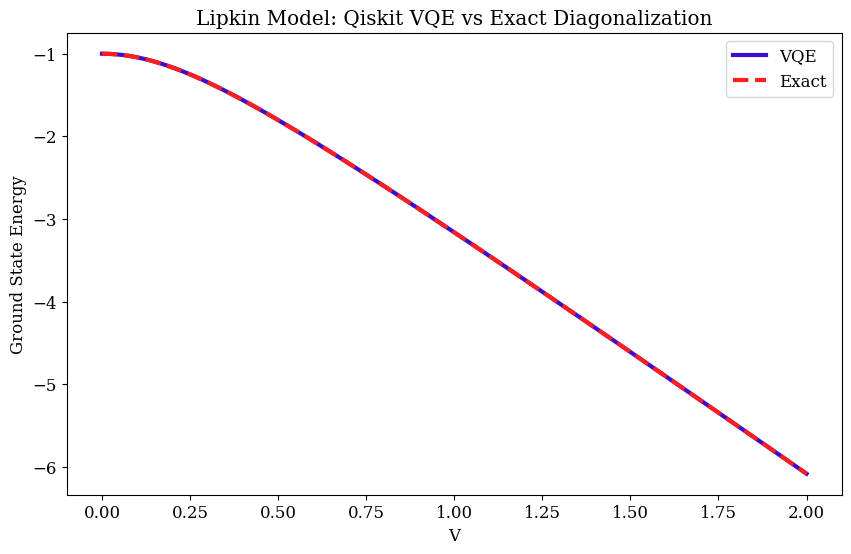

In [48]:
# Plot results
plt.plot(V_values, vqe_results, label='VQE')
plt.plot(V_values, exact_results, '--', label='Exact')
plt.xlabel('V')
plt.ylabel('Ground State Energy')
plt.title('Lipkin Model: Qiskit VQE vs Exact Diagonalization')
plt.legend()
plt.savefig('figs/f_lipkin_vqe_vs_exact.pdf')
plt.savefig('selected_results/f_lipkin_vqe_vs_exact.pdf')
plt.show()

In [49]:
error_statistics(result_lipkin)

+----------+-------------+
| Metric   | Error (%)   |
+==========+=============+
| Mean     | 5e-07%      |
| Median   | 4e-07%      |
| Max      | 1e-06%      |
| Min      | 6e-08%      |
| Std      | 2e-07%      |
+----------+-------------+


## <a id='toc10_1_'></a>[Conclusion](#toc0_)
- The VQE method was able to approximate the eigenvalues of the Hamiltonian matrix, with a relative error of $≈ 10^{-7}$. This was naturally slower than numpy, but a lot more performant than earlier implementation. 